# STE Estimator - Rev 3.6:
### Made Pairs by medid and device_naturalkey

Exp 3 - 5 features (Usage Rate - Inv - dist to eed-ssflag-max par - fixed rmvl cutoff 25 - fixed prediction cut off 200 or 50

Grouping for pairs with removals less than 4 times 
Inventory and EED got from mkp_es.PocketMonthlySnapShot instead of mkp_es.storagespaceinventory

- Proper Insulin exclusion (revised to be non-case sensistive)
- Rmvl_cutoff = 1000
- perdiction_cutoff per pair
- Replace dist to NULL EED with the average dist to eed per pair
- Mean Absolute Error (MAE) is added
- Exclusions by medfullname w keyword:
    - patient
    - insuli
    - expir XXXXXXXXXXX
    - outdat XXXXXXXXXXX
    - plase XXXXXXXXXXX
- Exlusions by medid w keyword: XXXXXXXXXXX
    - idvrip XXXXXXXXXXX
- Exclusion when Max par is not greater than Min par XXXXXXXXXXX

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import json
import time
from datetime import datetime
import os
import logging
from collections import Counter
pd.options.mode.chained_assignment='raise'


In [90]:
ts = datetime.now().strftime("%Y%m%d-%I%M") #, encoding='utf-8'
logging.basicConfig(filename='Log_STE_Hybrid.log',level=logging.DEBUG)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
#logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [91]:
def log_warning(log_text):
    ts = datetime.now().strftime("%m/%d/%Y %I:%M:%S %p")
    logging.warning(str(ts)+'\t'+log_text)

def log_debug(log_text):
    ts = datetime.now().strftime("%m/%d/%Y %I:%M:%S %p")
    logging.debug(str(ts)+'\t'+log_text)

log_warning('This message should go to the log file')
log_debug('This message should go to the log file')

In [92]:
def read_inputs(input_directory, read_json):
    os.chdir(input_directory)
    if read_json:
        # Read the file names (JSON)
        with open('STEinputFiles.json') as f:
            inputs = json.load(f) 
        # Outdate and Destock Transactions
        df_tranx = pd.read_csv(inputs['df_tranx'],parse_dates=['transactionlocaldatetime'],dtype={'medid': str})    

        # Unit cost table and medid-medkey mapping from MKP_ES.item
        unitcost = pd.read_csv(inputs['unitcost'],dtype={'medid': str}).rename(columns={'clientkey':'skclientkey'})    

        # usage rate for both sites
        usage = pd.read_csv(inputs['usage'],dtype={'medid': str}).rename(columns={'clientkey':'skclientkey','devicename':'dispensingdevicename'})    

        date_parser = lambda c: pd.to_datetime(c, format='%Y%m%d', errors='coerce')

        # Inventory, EED, and Standard Stock Flag (pocket monthly snapshot)
        inv_eed_ssflag = pd.read_csv(inputs['inv_eed_ssflag'],parse_dates=['lastday_of_month','earliestnextexpirationdate'], date_parser = date_parser,dtype={'medid': str})

        # Add monthfirstday column and 
        inv_eed_ssflag.loc[:,'monthfirstday'] = (inv_eed_ssflag['lastday_of_month'] + timedelta(days=1)).astype('datetime64',copy=False)
        all_mednames = pd.read_csv(inputs['all_mednames'])
        all_devicenames = pd.read_csv(inputs['all_devicenames'])
    else:
        # Outdate and Destock Transactions
        df_tranx = pd.read_csv('12130-10550-tranx-impala-medid-ddname.csv',parse_dates=['transactionlocaldatetime'],dtype={'medid': str})

        # Unit cost table and medid-medkey mapping from MKP_ES.item
        unitcost = pd.read_csv('unitcost_10550_12310.csv',dtype={'medid': str}).rename(columns={'clientkey':'skclientkey'})

        # usage rate for both sites
        usage_12310 = pd.read_csv('Averagedailyusage-10023.csv',dtype={'medid': str})
        usage = usage_12310.rename(columns={'clientkey':'skclientkey','devicename':'dispensingdevicename'})

        date_parser = lambda c: pd.to_datetime(c, format='%Y%m%d', errors='coerce')

        # Inventory, EED, and Standard Stock Flag (pocket monthly snapshot)
        inv_eed_ssflag = pd.read_csv('10023-Inv-EED',parse_dates=['lastday_of_month','earliestnextexpirationdate'], date_parser = date_parser,dtype={'medid': str})

        # Add monthfirstday column and 
        inv_eed_ssflag.loc[:, 'monthfirstday'] = (inv_eed_ssflag['lastday_of_month'] + timedelta(days=1)).astype('datetime64',copy=False)
        all_mednames = pd.read_csv('10550-12310 medfulnames.csv')
        all_devicenames = pd.read_csv('10550-12310 devicenames.csv')
    return df_tranx, inv_eed_ssflag, usage, unitcost, all_mednames, all_devicenames


In [93]:
input_directory=r'C:\Users\10336314\Desktop\Sprint_17\10023_Rush_Univesity_Medicalcentre\data'
read_json=True
df_tranx, inv_eed_ssflag, usage, unitcost, all_mednames, all_devicenames=read_inputs(input_directory,read_json)
df_tranx

,itemtransactionkey,skclientkey,itemtransactionrootkey,transactionsessionkey,itemtransactiontypekey,txtimekey,itemrootkey,itemkey,medkey,meditemrootkey,...,estransactiontypekey,legacytransactiontypekey,ismeddeviceexclude,ismedexclude,isdeviceexclude,transactionquantity,actualbegincount,hdp_shardid,medid,dispensingdevicename
0,-9223372032512675280,10023,2190069284,-941951117,-2147461006,20201203,-2140990034,-2137713941,-2104260472,-2140990034,...,13,13,False,False,False,2.0,5.0,7,16834,T08LD
1,-9223372032399224143,10023,2303150637,-912362009,-2147461006,20210126,-2140990034,-2137713941,-2104260472,-2140990034,...,13,13,False,False,False,2.0,4.0,7,16834,T08LD
2,-9223372032530593536,10023,2172212930,-946645114,-2147461006,20201124,-2140990034,-2137713941,-2104260472,-2140990034,...,13,13,False,False,False,1.0,4.0,7,16834,T08LD
3,-9223372033015610718,10023,1688812485,-1075030863,-2147461006,20200306,-2140990034,-2137713941,-2106942397,-2140990034,...,13,13,False,False,False,2.0,4.0,7,16834,T08LD
4,-9223372032512691378,10023,2190053229,-941955557,-2147461006,20201203,-2140990034,-2137713941,-2104260472,-2140990034,...,13,13,False,False,False,2.0,5.0,7,16834,T08LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20819,-9223372032760879891,10023,1942718631,-1007431319,-2147461006,20200730,-2143518669,-2141516441,-2106864427,-2143518669,...,13,13,True,True,False,2.0,6.0,7,0030,T07RX
20820,-9223372032502554722,10023,2200154507,-939296268,-2147461006,20201208,-2143518669,-2141516441,-2106864427,-2143518669,...,13,13,True,True,False,2.0,2.0,7,0030,RSI - T10SW
20821,-9223372032495782271,10023,2206905093,-937514962,-2147461006,20201211,-2143518669,-2141516441,-2106864427,-2143518669,...,13,13,True,True,False,1.0,1.0,7,0030,T07PACU
20822,-9223372032700409418,10023,2002982756,-991485242,-2147461006,20200831,-2143518669,-2141516441,-2106864427,-2143518669,...,13,13,True,True,False,1.0,2.0,7,0030,RSI - T10SW


In [94]:
# input_directory=r'C:\Users\10336314\Desktop\Sprint_17\IOA_sites\10023_Rush_Univesity_Medicalcentre\data'
# read_json-True
# df_tranx, inv_eed_ssflag, usage, unitcost=read_inputs(input_directory, read_json)

In [95]:
def log_duplicates(log_text,df,description_col,key_col):
    test = df.groupby(['skclientkey',key_col]).count().reset_index().rename({0:'count'})
    if ~test.loc[test[description_col] > 1].empty:
        test.loc[test[description_col] > 1].to_csv('Duplicated rows when adding '+description_col+'.csv')
        log_debug(log_text+ 'Duplicated rows when adding '+description_col+'to the test/training dataset')

## Get Latest med full name per med id

In [96]:
def get_latest_tranx_medid_clinetkey(df_tranx):
    latest_tranx_medid_clinetkey = df_tranx[['skclientkey','medid','transactionlocaldatetime']].groupby(['skclientkey','medid']).max()
    #print(latest_tranx_medid_clinetkey.count())
    medfullnames = df_tranx[['skclientkey','medid','transactionlocaldatetime','medfullname']].merge(latest_tranx_medid_clinetkey, how = 'inner' , on = ['skclientkey','medid','transactionlocaldatetime'])
    medfullnames = medfullnames.groupby(['skclientkey','medid','transactionlocaldatetime','medfullname']).size().reset_index()
    #print(medfullnames['skclientkey'].count())
    log_duplicates('duplicated med full names: ',medfullnames,'medfullname','medid')
    
    return medfullnames



In [97]:
medfullnames=get_latest_tranx_medid_clinetkey(df_tranx)
medfullnames

,skclientkey,medid,transactionlocaldatetime,medfullname,0
0,10023,0030,2021-05-25 07:40:56,RSI MEDS (RSI MEDS),1
1,10023,0048,2021-02-24 15:33:41,KEY FOR ANESTHESIA RETURN BIN (KEY FOR ANESTHE...,1
2,10023,0050,2021-04-10 13:19:06,PYXIS STAGING ROOM (PYXIS STAGING ROOM) Keys,1
3,10023,010014,2021-05-25 09:35:36,KEY FOR 201 Kellog (KEY FOR 201 Kellogg) Keys,1
4,10023,0102,2021-05-24 20:09:07,KEY FOR PYXIS REPAIR (KEY FOR PYXIS REPAIR) Keys,1
...,...,...,...,...,...
1055,10023,T1165,2021-04-03 11:53:50,NARC PT SPEC RM# 1165....1171 (NARC PT SPEC RM...,1
1056,10023,T1172,2021-05-26 10:02:10,NARC PT SPEC RM# 1172....1178 (NARC PT SPEC RM...,1
1057,10023,TBT05PACU,2021-05-28 12:15:03,TRANSPORT BOX - T05PACU (TRANSPORT BOX - T05PA...,1
1058,10023,code tray,2020-11-03 17:02:55,CODE MEDICATION TRAY (CODE MEDICATION TRAY) MISC,1


## Get Latest dispence device per med id

In [98]:
def get_latest_tranx_dispensingdevicename_clinetkey(df_tranx):
    latest_tranx_device_naturalkey_clinetkey = df_tranx[['skclientkey','device_naturalkey','transactionlocaldatetime']].groupby(['skclientkey','device_naturalkey']).max()
    #print(latest_tranx_medid_clinetkey.count())
    dispensingdevicenames = df_tranx[['skclientkey','device_naturalkey','transactionlocaldatetime','dispensingdevicename']].merge(latest_tranx_device_naturalkey_clinetkey, how = 'inner' , on = ['skclientkey','device_naturalkey','transactionlocaldatetime'])
    dispensingdevicenames = dispensingdevicenames.groupby(['skclientkey','device_naturalkey','transactionlocaldatetime','dispensingdevicename']).size().reset_index()
    log_duplicates('duplicated dispensing device names: ',dispensingdevicenames,'dispensingdevicename','device_naturalkey')  
    return dispensingdevicenames


In [99]:
dispensingdevicenames=get_latest_tranx_dispensingdevicename_clinetkey(df_tranx)
dispensingdevicenames


,skclientkey,device_naturalkey,transactionlocaldatetime,dispensingdevicename,0
0,10023,-2147458038,2021-05-29 21:15:11,ANESTOR29,1
1,10023,-2147458036,2021-05-28 22:23:25,ANEST07BU,1
2,10023,-2147458034,2021-05-30 21:07:52,ANESTOR30,1
3,10023,-2147458033,2021-05-29 21:07:17,ANESTOR31,1
4,10023,-2147458032,2021-05-29 21:04:07,ANESTOR32,1
...,...,...,...,...,...
150,10023,-2147448651,2021-05-27 22:49:34,A09NW,1
151,10023,-2147437298,2021-05-30 21:49:21,ANESAOR5,1
152,10023,-2147428217,2021-05-30 21:50:24,ANESAOR7,1
153,10023,-2147428216,2021-05-25 15:41:48,T08NICUA,1


## Client Key

In [100]:
def get_clientkeys(df_tranx):
    cks=''
    ck_list = []
    for ck in df_tranx.skclientkey.unique():
        cks += str(ck) + '_'
        ck_list.append(ck)
    cks = cks[0:len(cks)-1]
    return ck_list, cks

In [101]:
ck_list,cks=get_clientkeys(df_tranx)
cks

'10023'

In [102]:
def get_clientkeys_and_cutoffs(df_tranx):
    clients_list, clients = get_clientkeys(df_tranx) #'13961_11537_16317'
    print(clients, clients_list)

    # Default values for the parameters, Different values would be used based on the training data
    Inv_cutoff = 1000
    Rmvl_cutoff = 1000
    prediction_cutoff = 50#200#
    return clients_list, clients, Inv_cutoff, Rmvl_cutoff, prediction_cutoff

In [103]:
clients_list, clients, Inv_cutoff, Rmvl_cutoff, prediction_cutoff=get_clientkeys_and_cutoffs(df_tranx)

10023 [10023]


In [104]:
prediction_cutoff

50

In [105]:
inv_eed_ssflag

,skclientkey,hdp_shardid,lastday_of_month,medid,dispensingdevicename,devicetypekey,meditemflag,device_naturalkey,isinactive,inventoryquantity,earliestnextexpirationdate,standardstockwithindispensingdeviceflag,max_par_level,min_par_level,monthfirstday
0,10023,7,2020-06-30,3134,T14SW,2,True,-2147457924,0,16,2021-02-28,0,40,10,2020-07-01
1,10023,7,2020-05-31,12509,T14NW,2,True,-2147457923,0,13,2021-03-31,0,20,6,2020-06-01
2,10023,7,2021-04-30,1490,T14NE,2,True,-2147457922,0,10,2022-02-26,0,10,4,2021-05-01
3,10023,7,2020-08-31,12194,A05ORE,2,True,-2147457982,0,3,2021-04-30,0,4,2,2020-09-01
4,10023,7,2020-02-29,3371,ANESAOR3,4,True,-2147457997,0,2,2020-12-31,0,2,1,2020-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301656,10023,7,2021-03-31,2128,T12NW,2,True,-2147457909,0,26,2021-09-30,0,40,12,2021-04-01
301657,10023,7,2021-01-31,1649,ANESTLD1,4,True,-2147457990,0,2,2022-05-31,0,2,4,2021-02-01
301658,10023,7,2020-08-31,3032,T10NE,2,True,-2147457900,0,19,2022-03-31,0,20,6,2020-09-01
301659,10023,7,2020-06-30,5185,T14SE,2,True,-2147457921,0,14,2020-11-08,0,12,4,2020-07-01


## Add dist eed 

In [106]:
def add_dist_eed(inv_eed_ssflag):
    tmp_inv_eed_ssflag = inv_eed_ssflag
    
    NUll_tmp_rplcmt = 99999999
    tmp_inv_eed_ssflag['dist_eed'] = ((tmp_inv_eed_ssflag['earliestnextexpirationdate'] - tmp_inv_eed_ssflag['monthfirstday'])/np.timedelta64(1, 'D')).fillna(NUll_tmp_rplcmt).astype(int)

    inv_eed_ssflag_no_Null_EED = tmp_inv_eed_ssflag.loc[~np.isnan(tmp_inv_eed_ssflag['earliestnextexpirationdate'])][['skclientkey','medid','device_naturalkey','dist_eed']]
    inv_eed_ssflag_w_average_dist_eed = np.floor(inv_eed_ssflag_no_Null_EED.groupby(['skclientkey','medid','device_naturalkey']).mean()).reset_index().rename(columns={'dist_eed':'avg_dist_eed'})
    
    tmp_inv_eed_ssflag = tmp_inv_eed_ssflag.merge(inv_eed_ssflag_w_average_dist_eed, on = ['skclientkey','medid','device_naturalkey'], how = 'left')
    tmp_inv_eed_ssflag.loc[(tmp_inv_eed_ssflag['dist_eed'] == NUll_tmp_rplcmt) & (~np.isnan(tmp_inv_eed_ssflag['avg_dist_eed'])),'dist_eed'] = tmp_inv_eed_ssflag['avg_dist_eed']
    
    tmp_inv_eed_ssflag.loc[(tmp_inv_eed_ssflag['dist_eed'] == NUll_tmp_rplcmt), 'dist_eed'] = 0
    
    return tmp_inv_eed_ssflag

In [107]:
tmp_inv_eed_ssflag=add_dist_eed(inv_eed_ssflag)
tmp_inv_eed_ssflag

,skclientkey,hdp_shardid,lastday_of_month,medid,dispensingdevicename,devicetypekey,meditemflag,device_naturalkey,isinactive,inventoryquantity,earliestnextexpirationdate,standardstockwithindispensingdeviceflag,max_par_level,min_par_level,monthfirstday,dist_eed,avg_dist_eed
0,10023,7,2020-06-30,3134,T14SW,2,True,-2147457924,0,16,2021-02-28,0,40,10,2020-07-01,242.0,414.0
1,10023,7,2020-05-31,12509,T14NW,2,True,-2147457923,0,13,2021-03-31,0,20,6,2020-06-01,303.0,294.0
2,10023,7,2021-04-30,1490,T14NE,2,True,-2147457922,0,10,2022-02-26,0,10,4,2021-05-01,301.0,316.0
3,10023,7,2020-08-31,12194,A05ORE,2,True,-2147457982,0,3,2021-04-30,0,4,2,2020-09-01,241.0,225.0
4,10023,7,2020-02-29,3371,ANESAOR3,4,True,-2147457997,0,2,2020-12-31,0,2,1,2020-03-01,305.0,322.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301656,10023,7,2021-03-31,2128,T12NW,2,True,-2147457909,0,26,2021-09-30,0,40,12,2021-04-01,182.0,139.0
301657,10023,7,2021-01-31,1649,ANESTLD1,4,True,-2147457990,0,2,2022-05-31,0,2,4,2021-02-01,484.0,296.0
301658,10023,7,2020-08-31,3032,T10NE,2,True,-2147457900,0,19,2022-03-31,0,20,6,2020-09-01,576.0,520.0
301659,10023,7,2020-06-30,5185,T14SE,2,True,-2147457921,0,14,2020-11-08,0,12,4,2020-07-01,130.0,107.0


In [108]:
# Add year month integer index for the aggregation
# inv_eed_ssflag['month']= ((pd.DatetimeIndex(inv_eed_ssflag['monthfirstday']).year*100+pd.DatetimeIndex(inv_eed_ssflag['monthfirstday']).month)-202000).astype(int)


# inv_eed_ssflag['ymint']= (pd.DatetimeIndex(inv_eed_ssflag['monthfirstday']).year*100+pd.DatetimeIndex(inv_eed_ssflag['monthfirstday']).month).astype(int)


# # Distance to EED -- Fill NaNs with average dist_eed per pair
# inv_eed_ssflag = add_dist_eed(inv_eed_ssflag)

# # Categorical: (> 120) --> 0 (< 0) --> 2 (<= 120) --> 1
# inv_eed_ssflag['dist_eed_120'] = np.where(inv_eed_ssflag['dist_eed'] > 120, 0, np.where(inv_eed_ssflag['dist_eed'] < 0,2, 1))

In [109]:
def log_empty_df(function_name, df):
    if df.empty:
        log_debug('Something is wrong!!! '+function_name+' outcome is empty')

In [110]:
def remove_non_drug_items(df):
    
    df_tmp = pd.DataFrame()
    drug_item_flag = 'meditemflag'
    if drug_item_flag in df.columns:
        df_tmp = df.loc[df[drug_item_flag] == 1]        
    else:
        log_debug(drug_item_flag+ ' column is missed in input prepared dataset (all)')

    log_empty_df('remove_non_drug_items', df_tmp)
    return df_tmp    

In [111]:
def remove_insulins(df, clients):
    med_name_column = 'medfulname'
    med_name_column_alt = 'medfullname'
    insulin_key = 'insuli'
    patient_key = 'patient'
    
    df_tmp = pd.DataFrame()    
    
    if med_name_column in df.columns:
        df_tmp = df.loc[~df[med_name_column].isnull()]
        df_tmp.loc[df_tmp[med_name_column].str.lower().str.contains(insulin_key)].to_csv('Insulins_'+clients+'.csv')
        df_tmp.loc[(df_tmp[med_name_column].str.lower().str.contains(insulin_key))
               |(df_tmp[med_name_column].str.lower().str.contains(patient_key))].to_csv('Exclusions_by_Medfulname_'+clients+'.csv')#.info() #255

        df_tmp = df_tmp.loc[~((df_tmp[med_name_column].str.lower().str.contains(insulin_key))
                          |(df_tmp[med_name_column].str.lower().str.contains(patient_key)))]
    elif med_name_column_alt in df.columns:
        df_tmp = df.loc[~df[med_name_column_alt].isnull()]
        df_tmp.loc[df_tmp[med_name_column_alt].str.lower().str.contains(insulin_key)].to_csv('Insulins_'+clients+'.csv')
        df_tmp.loc[(df_tmp[med_name_column_alt].str.lower().str.contains(insulin_key))
               |(df_tmp[med_name_column_alt].str.lower().str.contains(patient_key))].to_csv('Exclusions_by_Medfullname_'+clients+'.csv')#.info() #255

        df_tmp = df_tmp.loc[~((df_tmp[med_name_column_alt].str.lower().str.contains(insulin_key))
                          |(df_tmp[med_name_column_alt].str.lower().str.contains(patient_key)))]
    else:    
        log_debug(med_name_column+ ' column is missed in input prepared dataset (all)')
        
    log_empty_df('remove_insulins', df_tmp)
    return df_tmp


In [112]:
df_tmp=remove_insulins(df_tranx, clients)
df_tmp

,itemtransactionkey,skclientkey,itemtransactionrootkey,transactionsessionkey,itemtransactiontypekey,txtimekey,itemrootkey,itemkey,medkey,meditemrootkey,...,estransactiontypekey,legacytransactiontypekey,ismeddeviceexclude,ismedexclude,isdeviceexclude,transactionquantity,actualbegincount,hdp_shardid,medid,dispensingdevicename
0,-9223372032512675280,10023,2190069284,-941951117,-2147461006,20201203,-2140990034,-2137713941,-2104260472,-2140990034,...,13,13,False,False,False,2.0,5.0,7,16834,T08LD
1,-9223372032399224143,10023,2303150637,-912362009,-2147461006,20210126,-2140990034,-2137713941,-2104260472,-2140990034,...,13,13,False,False,False,2.0,4.0,7,16834,T08LD
2,-9223372032530593536,10023,2172212930,-946645114,-2147461006,20201124,-2140990034,-2137713941,-2104260472,-2140990034,...,13,13,False,False,False,1.0,4.0,7,16834,T08LD
3,-9223372033015610718,10023,1688812485,-1075030863,-2147461006,20200306,-2140990034,-2137713941,-2106942397,-2140990034,...,13,13,False,False,False,2.0,4.0,7,16834,T08LD
4,-9223372032512691378,10023,2190053229,-941955557,-2147461006,20201203,-2140990034,-2137713941,-2104260472,-2140990034,...,13,13,False,False,False,2.0,5.0,7,16834,T08LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20819,-9223372032760879891,10023,1942718631,-1007431319,-2147461006,20200730,-2143518669,-2141516441,-2106864427,-2143518669,...,13,13,True,True,False,2.0,6.0,7,0030,T07RX
20820,-9223372032502554722,10023,2200154507,-939296268,-2147461006,20201208,-2143518669,-2141516441,-2106864427,-2143518669,...,13,13,True,True,False,2.0,2.0,7,0030,RSI - T10SW
20821,-9223372032495782271,10023,2206905093,-937514962,-2147461006,20201211,-2143518669,-2141516441,-2106864427,-2143518669,...,13,13,True,True,False,1.0,1.0,7,0030,T07PACU
20822,-9223372032700409418,10023,2002982756,-991485242,-2147461006,20200831,-2143518669,-2141516441,-2106864427,-2143518669,...,13,13,True,True,False,1.0,2.0,7,0030,RSI - T10SW


In [113]:
def remove_anesthesia_stations(df, clients):
    df_tmp = pd.DataFrame()
    devicetype = 'devicetypekey'
    if (devicetype in df.columns):
        df.loc[(df[devicetype] == 4)|(df[devicetype] == 6)|(df[devicetype] == 7)].to_csv('Anesthesia_Station_Mini_Trays_'+clients+'.csv')
        df_tmp = df.loc[(df[devicetype] == 1)|(df[devicetype] == 2)]#.info() #11509
    else:
        log_debug(devicetype+ ' column is missed in input prepared dataset (all)')

    log_empty_df('remove_anesthesia_stations', df_tmp)
    return df_tmp

In [114]:
def remove_outofrange_inv(df, Inv_cutoff):
    df_tmp = pd.DataFrame()
    inv = 'inventoryquantity'
    if (inv in df.columns):
        df_tmp = df.loc[df[inv] <= Inv_cutoff]
    else:
        log_debug(inv+ ' column is missed in input prepared dataset (all)')
    
    log_empty_df('remove_outofrange_inv', df_tmp)
    return df_tmp

In [115]:
def apply_STE_exclusions(name, df_all, Inv_cutoff, clients):
    df_all_tmp1 = remove_non_drug_items(df_all)
    df_all_tmp2 = remove_insulins(df_all_tmp1, clients)
    df_all_tmp3 = remove_anesthesia_stations(df_all_tmp2, clients)
    df_all_tmp = remove_outofrange_inv(df_all_tmp3, Inv_cutoff)
    #ts = datetime.now().strftime("%Y%m%d-%I%M")
    df_all_tmp.to_csv(name+'_'+clients+'.csv',index=False)
    log_empty_df('apply_STE_exclusions', df_all_tmp)
    return df_all_tmp

In [116]:
def add_required_columns(inv_eed_ssflag, df_tranx, usage):
    # Add year month integer index for the aggregation
    inv_eed_ssflag['month']= ((pd.DatetimeIndex(inv_eed_ssflag['monthfirstday']).year*100+pd.DatetimeIndex(inv_eed_ssflag['monthfirstday']).month)-202000).astype(int)


    inv_eed_ssflag['ymint']= (pd.DatetimeIndex(inv_eed_ssflag['monthfirstday']).year*100+pd.DatetimeIndex(inv_eed_ssflag['monthfirstday']).month).astype(int)


    # Distance to EED -- Fill NaNs with average dist_eed per pair
    inv_eed_ssflag = add_dist_eed(inv_eed_ssflag)

    # Categorical: (> 120) --> 0 (< 0) --> 2 (<= 120) --> 1
    inv_eed_ssflag['dist_eed_120'] = np.where(inv_eed_ssflag['dist_eed'] > 120, 0, np.where(inv_eed_ssflag['dist_eed'] < 0,2, 1))
    
    # Categorical: (> 90) --> 0 (< 0) --> 2 (<= 90) --> 1
    inv_eed_ssflag['dist_eed_90'] = np.where(inv_eed_ssflag['dist_eed'] > 90, 0, np.where(inv_eed_ssflag['dist_eed'] < 0,2, 1))

    # Add year month integer index for the aggregation
    df_tranx['ymint']= pd.DatetimeIndex(df_tranx['transactionlocaldatetime']).year*10000+pd.DatetimeIndex(df_tranx['transactionlocaldatetime']).month*100

    usage['ymint']=(usage['year_month']*100).astype('int64')+100

    #usage['ymint'] = usage['ymint'].replace(20191300, 20200100)# use Dec 2020 usage for Dec 2019
    #usage['ymint'] = usage['ymint'].replace(20201300, 20210100)# use Dec 2020 usage for Dec 2019

    # Replace 20191300 with 20200100 and 20201300 with 20210100

    usage['ymint']=usage['ymint'].apply(lambda x:((x//10000)+1)*10000+100 if (x%10000)>1200 else x)


    usage['month']=(round(usage['ymint']/100)-202000).astype(int)
    usage['100avgdailyusage30']=(usage['avgdailyusage30']*100).astype('int64')
    #print(usage.month.head())

    return inv_eed_ssflag, df_tranx, usage

In [117]:
inv_eed_ssflag, df_tranx, usage=add_required_columns(inv_eed_ssflag, df_tranx, usage)
usage

,hdp_shardid,skclientkey,medkey,medid,dispensingdevicename,device_naturalkey,iscontrolledmed,isactive,ismedexcluded,isshortageexcluded,year_month,avgdailyusage30,usage_count30,minusagedatekey,maxusagedatekey,number_of_activedays,ymint,month,100avgdailyusage30
0,7,10023,508609,14426,K09S,-2147457979,False,True,False,False,202002.0,0.133333,4,20200207,20200225,4,20200300,3,13
1,7,10023,507542,16545,,-2147458041,True,True,False,False,202003.0,0.000000,0,20200301,20200327,20,20200400,4,0
2,7,10023,508749,1033,T11NE,-2147457907,False,True,False,False,202004.0,0.033333,1,20200414,20200422,2,20200500,5,3
3,7,10023,507517,2293,ANESTOR38,-2147458026,False,True,False,False,202010.0,0.033333,1,20201013,20201014,2,20201100,11,3
4,7,10023,508321,3492,EDB,-2147457879,False,True,False,False,202104.0,0.300000,9,20210402,20210428,11,20210500,105,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245842,7,10023,507206,14097,K06,-2147457938,False,True,False,False,202009.0,0.200000,4,20200925,20200929,4,20201000,10,20
245843,7,10023,509290,4780,T13NW,-2147457885,False,True,False,False,202105.0,0.400000,12,20210522,20210529,6,20210600,106,40
245844,7,10023,509636,5727,T13NE,-2147457914,False,True,False,False,202011.0,0.033333,1,20201107,20201107,1,20201200,12,3
245845,7,10023,507882,7315,A09SE,-2147457896,True,True,False,False,202007.0,1.166667,20,20200707,20200727,9,20200800,8,116


In [118]:
def build_required_dataframes(df_tranx, inv_eed_ssflag, usage, unitcost, Rmvl_cutoff):        
    
    # For one site
    # aggregate at devicename-medid level
    df_tranx_grouped = df_tranx[['hdp_shardid','skclientkey','ymint','medid','device_naturalkey','transactionquantity','actualbegincount']].loc[df_tranx['transactionquantity'] <= Rmvl_cutoff].groupby(['hdp_shardid','skclientkey','ymint','medid','device_naturalkey']).sum().reset_index()

    # add unit cost - left join and fill NAs with 0
    df_tranx_grouped_unitcost = pd.merge(df_tranx_grouped,unitcost, how = "left" ,on = ["hdp_shardid","skclientkey","medid"])

    # add usage
    df_tranx_grouped_unitcost_usage = pd.merge(df_tranx_grouped_unitcost,usage[['hdp_shardid', 'skclientkey','medid','device_naturalkey','ymint','avgdailyusage30','100avgdailyusage30']], how = "left" ,on = ["hdp_shardid","skclientkey","medid","device_naturalkey","ymint"])

    # Fill NaNs with 0
    df_tranx_grouped_unitcost_usage['unitcost'] = df_tranx_grouped_unitcost_usage['unitcost'].fillna(0)
    df_tranx_grouped_unitcost_usage['100avgdailyusage30'] = df_tranx_grouped_unitcost_usage['100avgdailyusage30'].fillna(0)

    # Convert ymint of format "yyyymm00" to show integer month only
    #month when 2020, 100+month when 2021
    df_tranx_grouped_unitcost_usage['month'] = ((df_tranx_grouped_unitcost_usage['ymint']-20200000)/100).astype(int)

    #only month number regardless of the year
    df_tranx_grouped_unitcost_usage['month2'] = ((df_tranx_grouped_unitcost_usage['ymint'])/100).mod(100).astype(int)

    # Add distance to EED, Standard STock flag and Inventory Quantity

    df_tranx_all_grouped = pd.merge(df_tranx_grouped_unitcost_usage,inv_eed_ssflag[['hdp_shardid', 'skclientkey','medid', 'device_naturalkey','month','inventoryquantity','standardstockwithindispensingdeviceflag','dist_eed','dist_eed_120','max_par_level','min_par_level','devicetypekey','meditemflag']], how = "left" ,on = ["hdp_shardid","skclientkey","medid","device_naturalkey","month"])
    df_medfullnames = get_latest_tranx_medid_clinetkey(df_tranx).reset_index()
    df_dispensingdevicenames = get_latest_tranx_dispensingdevicename_clinetkey(df_tranx).reset_index()
    return df_tranx_grouped, df_tranx_all_grouped, df_medfullnames, df_dispensingdevicenames


In [119]:
df_tranx_grouped, df_tranx_all_grouped, df_medfullnames, df_dispensingdevicenames=build_required_dataframes(df_tranx, inv_eed_ssflag, usage, unitcost, Rmvl_cutoff)
df_tranx_all_grouped

,hdp_shardid,skclientkey,ymint,medid,device_naturalkey,transactionquantity,actualbegincount,lastmodifieddatetime,unitcost,sourcesystemkey,...,month,month2,inventoryquantity,standardstockwithindispensingdeviceflag,dist_eed,dist_eed_120,max_par_level,min_par_level,devicetypekey,meditemflag
0,7,10023,20200300,0030,-2147457957,25.0,66.0,NaN,0.0,NaN,...,3,3,6.0,0.0,2.0,1.0,5.0,2.0,1.0,True
1,7,10023,20200300,0030,-2147457879,3.0,8.0,NaN,0.0,NaN,...,3,3,2.0,0.0,2.0,1.0,4.0,2.0,2.0,True
2,7,10023,20200300,0030,-2147454806,6.0,8.0,NaN,0.0,NaN,...,3,3,4.0,0.0,2.0,1.0,5.0,4.0,1.0,True
3,7,10023,20200300,0103,-2147457981,5.0,5.0,NaN,0.0,NaN,...,3,3,1.0,0.0,0.0,1.0,1.0,0.0,1.0,True
4,7,10023,20200300,10001,-2147458021,1.0,1.0,2020-05-22 08:11:50.203,0.0,2.0,...,3,3,0.0,0.0,0.0,1.0,10.0,9.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12834,7,10023,20210500,T1101,-2147457901,2.0,2.0,2020-05-22 08:11:50.203,0.0,2.0,...,105,5,1.0,1.0,0.0,1.0,10.0,9.0,2.0,True
12835,7,10023,20210500,T1115,-2147457903,2.0,2.0,2020-05-22 08:11:50.203,0.0,2.0,...,105,5,0.0,1.0,0.0,1.0,10.0,9.0,2.0,True
12836,7,10023,20210500,T1123,-2147457903,1.0,2.0,2020-05-22 08:11:50.203,0.0,2.0,...,105,5,0.0,1.0,0.0,1.0,10.0,9.0,2.0,True
12837,7,10023,20210500,T1172,-2147457907,11.0,17.0,2020-05-22 08:11:50.203,0.0,2.0,...,105,5,1.0,1.0,0.0,1.0,10.0,9.0,2.0,True


In [120]:
def drop_null_inv(df_tranx_all_grouped, clients):
    ### Null Inventory Quantity Count = 26,530 ['medid','dispensingdevicename','month'] reduced -->  1807 
    #df_tranx_all_grouped[['medid','device_naturalkey','month','inventoryquantity']].loc[df_tranx_all_grouped['inventoryquantity'].isnull()].info()#.to_csv('Null Inventory Quantity Count.csv')
    df_tranx_all_grouped[['skclientkey','medid','device_naturalkey','month','transactionquantity','inventoryquantity']].loc[df_tranx_all_grouped['inventoryquantity'].isnull()].to_csv('Null Inventory Quantity Count_'+clients+'.csv')
    #df_tranx_all_grouped_with_NAs[['medid','dispensingdevicename','month','inventoryquantity']].loc[df_tranx_all_grouped_with_NAs['inventoryquantity'].isnull()].head(10)

    #df_tranx_all_grouped[['medid','dispensingdevicename','month','inventoryquantity']].loc[df_tranx_all_grouped['inventoryquantity'].isnull()].info()

    # Create a copy of the data set before dropping the NAs
    df_tranx_all_grouped_with_NAs = df_tranx_all_grouped.copy()

    # Drop ROws with NAs in select features: ['month','100avgdailyusage30','inventoryquantity','dist_eed','standardstockwithindispensingdeviceflag']
    df_tranx_all_grouped = df_tranx_all_grouped[['hdp_shardid','skclientkey','medid','device_naturalkey','month','month2','100avgdailyusage30','inventoryquantity','dist_eed','standardstockwithindispensingdeviceflag','transactionquantity','actualbegincount','dist_eed_120','unitcost','max_par_level','min_par_level','devicetypekey','meditemflag']].dropna()
    return df_tranx_all_grouped, df_tranx_all_grouped_with_NAs

In [121]:
df_tranx_all_grouped, df_tranx_all_grouped_with_NAs=drop_null_inv(df_tranx_all_grouped, clients)
df_tranx_all_grouped_with_NAs

,hdp_shardid,skclientkey,ymint,medid,device_naturalkey,transactionquantity,actualbegincount,lastmodifieddatetime,unitcost,sourcesystemkey,...,month,month2,inventoryquantity,standardstockwithindispensingdeviceflag,dist_eed,dist_eed_120,max_par_level,min_par_level,devicetypekey,meditemflag
0,7,10023,20200300,0030,-2147457957,25.0,66.0,NaN,0.0,NaN,...,3,3,6.0,0.0,2.0,1.0,5.0,2.0,1.0,True
1,7,10023,20200300,0030,-2147457879,3.0,8.0,NaN,0.0,NaN,...,3,3,2.0,0.0,2.0,1.0,4.0,2.0,2.0,True
2,7,10023,20200300,0030,-2147454806,6.0,8.0,NaN,0.0,NaN,...,3,3,4.0,0.0,2.0,1.0,5.0,4.0,1.0,True
3,7,10023,20200300,0103,-2147457981,5.0,5.0,NaN,0.0,NaN,...,3,3,1.0,0.0,0.0,1.0,1.0,0.0,1.0,True
4,7,10023,20200300,10001,-2147458021,1.0,1.0,2020-05-22 08:11:50.203,0.0,2.0,...,3,3,0.0,0.0,0.0,1.0,10.0,9.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12834,7,10023,20210500,T1101,-2147457901,2.0,2.0,2020-05-22 08:11:50.203,0.0,2.0,...,105,5,1.0,1.0,0.0,1.0,10.0,9.0,2.0,True
12835,7,10023,20210500,T1115,-2147457903,2.0,2.0,2020-05-22 08:11:50.203,0.0,2.0,...,105,5,0.0,1.0,0.0,1.0,10.0,9.0,2.0,True
12836,7,10023,20210500,T1123,-2147457903,1.0,2.0,2020-05-22 08:11:50.203,0.0,2.0,...,105,5,0.0,1.0,0.0,1.0,10.0,9.0,2.0,True
12837,7,10023,20210500,T1172,-2147457907,11.0,17.0,2020-05-22 08:11:50.203,0.0,2.0,...,105,5,1.0,1.0,0.0,1.0,10.0,9.0,2.0,True


In [122]:
def add_medfulname_dispensingdevicename(clients, df_tranx_all_grouped, df_medfullnames, df_dispensingdevicenames):
    if ('medfullname' not in df_tranx_all_grouped.columns):
        df_tranx_all_grouped = df_tranx_all_grouped.merge(df_medfullnames[['skclientkey','medid','medfullname']],how = 'left', on = ['skclientkey','medid'])
        #print('med full name has been added')
    else:
        print('med full name was already there')
    #df_tranx_all_grouped_medfullname.info() #11903  
    #df_tranx_all_grouped.info() #11903  

    if ('dispensingdevicename' not in df_tranx_all_grouped.columns):
        df_tranx_all_grouped = df_tranx_all_grouped.merge(df_dispensingdevicenames[['skclientkey','device_naturalkey','dispensingdevicename']],how = 'left', on = ['skclientkey','device_naturalkey'])
        #print('dispensing device name has been added')
    else:
        print('dispensing device name was already there')
    #df_tranx_all_grouped_medfullname.info() #11903  
    #df_tranx_all_grouped.info() #11903  
    return df_tranx_all_grouped

In [123]:
df_tranx_all_grouped=add_medfulname_dispensingdevicename(clients, df_tranx_all_grouped, df_medfullnames, df_dispensingdevicenames)
df_tranx_all_grouped

,hdp_shardid,skclientkey,medid,device_naturalkey,month,month2,100avgdailyusage30,inventoryquantity,dist_eed,standardstockwithindispensingdeviceflag,transactionquantity,actualbegincount,dist_eed_120,unitcost,max_par_level,min_par_level,devicetypekey,meditemflag,medfullname,dispensingdevicename
0,7,10023,0030,-2147457957,3,3,260.0,6.0,2.0,0.0,25.0,66.0,1.0,0.0,5.0,2.0,1.0,True,RSI MEDS (RSI MEDS),T07RX
1,7,10023,0030,-2147457879,3,3,10.0,2.0,2.0,0.0,3.0,8.0,1.0,0.0,4.0,2.0,2.0,True,RSI MEDS (RSI MEDS),EDB
2,7,10023,0030,-2147454806,3,3,30.0,4.0,2.0,0.0,6.0,8.0,1.0,0.0,5.0,4.0,1.0,True,RSI MEDS (RSI MEDS),RSI - T10SW
3,7,10023,0103,-2147457981,3,3,33.0,1.0,0.0,0.0,5.0,5.0,1.0,0.0,1.0,0.0,1.0,True,KEY FOR PYXIS RETURN BIN SET 1 (KEY FOR PYXIS ...,CFA
4,7,10023,10001,-2147458021,3,3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,10.0,9.0,2.0,True,NARC PATIENT SPECIFIC (NARC PATIENT SPECIFIC) .,K05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12649,7,10023,T1101,-2147457901,105,5,26.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0,10.0,9.0,2.0,True,NARC PT SPEC RM# 1101....1107 (NARC PT SPEC RM...,T11SW
12650,7,10023,T1115,-2147457903,105,5,33.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,10.0,9.0,2.0,True,NARC PT SPEC RM# 1115....1121 (NARC PT SPEC RM...,T11NW
12651,7,10023,T1123,-2147457903,105,5,16.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,10.0,9.0,2.0,True,NARC PT SPEC RM# 1122....1128 (NARC PT SPEC RM...,T11NW
12652,7,10023,T1172,-2147457907,105,5,176.0,1.0,0.0,1.0,11.0,17.0,1.0,0.0,10.0,9.0,2.0,True,NARC PT SPEC RM# 1172....1178 (NARC PT SPEC RM...,T11NE


In [124]:
df_tranx, inv_eed_ssflag, usage, unitcost, all_mednames, all_devicenames = read_inputs(input_directory, read_json)

In [125]:
def build_input_datafiles(input_directory, read_json):
    # read input files
    df_tranx, inv_eed_ssflag, usage, unitcost, all_mednames, all_devicenames = read_inputs(input_directory, read_json)
    # get clients and cutoffs
    clients_list, clients, Inv_cutoff, Rmvl_cutoff, prediction_cutoff = get_clientkeys_and_cutoffs(df_tranx)
    # add required columns
    inv_eed_ssflag, df_tranx, usage = add_required_columns(inv_eed_ssflag, df_tranx, usage)
    # build the model input dataset
    df_tranx_grouped, df_tranx_all_grouped, df_medfullnames, df_dispensingdevicenames = build_required_dataframes(df_tranx, inv_eed_ssflag, usage, unitcost, Rmvl_cutoff)
    # drop Null Inventories
    df_tranx_all_grouped, df_tranx_all_grouped_with_NAs = drop_null_inv(df_tranx_all_grouped, clients)
    # add medfulname dispensingdevicename
    df_tranx_all_grouped = add_medfulname_dispensingdevicename(clients, df_tranx_all_grouped, df_medfullnames, df_dispensingdevicenames)
    ## Apply the exclusions
    df_tranx_all_grouped = apply_STE_exclusions('df_tranx_all_grouped',df_tranx_all_grouped, Inv_cutoff, clients)
    return clients_list, clients, inv_eed_ssflag, usage, unitcost, all_mednames, all_devicenames, df_tranx_grouped, df_tranx_all_grouped

In [126]:
clients_list, clients, inv_eed_ssflag, usage, unitcost, all_mednames, all_devicenames, df_tranx_grouped, df_tranx_all_grouped=build_input_datafiles(input_directory, read_json)
all_mednames

10023 [10023]


,hdp_shardid,skclientkey,medid,medfulname
0,4,16339,5016523,BIOTIN (BIOTIN) 10000 mcg TAB
1,4,16339,5016470,DAPAGLIFLOZIN (FARXIGA) 5 mg TAB
2,4,16339,5016522,CHEWABLE MULTIVITAMIN (CHEWABLE MVI) TAB
3,4,16339,5016536,MEDIHONEY (MEDIHONEY) DRESSING
4,4,16339,5016535,POVIDONE-IODINE SWABSTICK (BETADINE) 10 % APPLIC
...,...,...,...,...
46706,3,13671,408,triamcinolone topical 0.1% (KENALOG) (15 g) Oi...
46707,3,13671,4179,rocuronium (ZEMURON) 100 mg (10 mL) Inj Vial
46708,3,13671,269,divalproex sodium DR (SPRINKLE) (DEPAKOTE SPRI...
46709,3,13671,2505,ceFAZolin in dextrose 5% in water (ANCEF) 2000...


In [127]:
# def get_training_months(averagedaily_df):
    
#     months = averagedaily_df.year_month.unique()
#     test_months = []
#     training_months=[] 
#     n = months.size-12-1
#     log_debug(str(n)+' months are found in the test set (usage)')
    
#     if (n > 0):
#         for i in range(0, n):

#             test_months.append(months.max())
#             months = np.setdiff1d(months,np.array(test_months))

#         training_months[:] = [number - 100 for number in test_months]
#     else:
#         log_warning('Not enough months of data in the usage input.')
#     return training_months

In [128]:
def build_df_all(inv_eed_ssflag, usage, unitcost, df_tranx_grouped, all_mednames, all_devicenames, clients,clients_list):
    #training_months = get_training_months(usage)
    training_months=202003
    month_cnt = 12
    #log_pair_count('inv_eed_ssflag', inv_eed_ssflag, training_months, month_cnt, clients_list)
    
    df_all_inv_usage = pd.merge(inv_eed_ssflag[['hdp_shardid', 'skclientkey','medid', 'device_naturalkey','ymint','month','inventoryquantity','standardstockwithindispensingdeviceflag','dist_eed','dist_eed_120','dist_eed_90','max_par_level','min_par_level','devicetypekey', 'meditemflag']],usage[['hdp_shardid', 'skclientkey','medid','device_naturalkey','month','avgdailyusage30','100avgdailyusage30']], how = "left" ,on = ["hdp_shardid","skclientkey","medid","device_naturalkey","month"])
    #log_pair_count('df_all_inv_usage', df_all_inv_usage, training_months, month_cnt, clients_list)

    df_all_inv_usage_unitcost = pd.merge(df_all_inv_usage, unitcost, how = 'left', on = ['hdp_shardid', 'skclientkey','medid'])
    #log_pair_count('df_all_inv_usage_unitcost', df_all_inv_usage_unitcost, training_months, month_cnt,clients_list)

    # ymint column in df_tranx_grouped is in 9 digits while in the df_all_inv_usage_unitcost, it is 5 digits 
    df_tranx_grouped2 = df_tranx_grouped.copy()
    df_tranx_grouped2.loc[:,'ymint'] = df_tranx_grouped2['ymint']/100
    df_all = pd.merge(df_all_inv_usage_unitcost ,df_tranx_grouped2, how = "left" ,on = ["hdp_shardid","skclientkey","medid","device_naturalkey","ymint"])#.fillna(0)
    #log_pair_count('df_all', df_all, training_months, month_cnt,clients_list)

    df_all[['avgdailyusage30','100avgdailyusage30', 'unitcost', 'transactionquantity']]=df_all[['avgdailyusage30','100avgdailyusage30', 'unitcost', 'transactionquantity']].fillna(0)
    df_all_mednames = df_all.merge(all_mednames[['skclientkey','medid','medfulname']], on = ["skclientkey", "medid"], how= 'left' )
    df_all_names = df_all_mednames.merge(all_devicenames[['skclientkey','device_naturalkey','dispensingdevicename']], on = ["skclientkey", "device_naturalkey"], how= 'left' )
    #log_pair_count('df_all_names', df_all_names,training_months, month_cnt,clients_list)
    
    debug_txt = df_all_names.loc[df_all_names['medfulname'].isnull()]['medid'].unique()
    if (debug_txt.size > 0):
        log_warning(' These Med Ids had no medfulname:\t' + debug_txt)
    
    #ts = datetime.now().strftime("%Y%m%d-%I%M")
    df_all_names.to_csv('df_all_'+clients+'_'+str(ts)+'.csv',index=False)
    return df_all_names

In [129]:
df_all_names=build_df_all(inv_eed_ssflag, usage, unitcost, df_tranx_grouped, all_mednames, all_devicenames, clients,clients_list)
df_all_names

,hdp_shardid,skclientkey,medid,device_naturalkey,ymint,month,inventoryquantity,standardstockwithindispensingdeviceflag,dist_eed,dist_eed_120,...,avgdailyusage30,100avgdailyusage30,lastmodifieddatetime,unitcost,sourcesystemkey,medkey,transactionquantity,actualbegincount,medfulname,dispensingdevicename
0,7,10023,3134,-2147457924,202007,7,16,0,242.0,0,...,0.300000,30.0,2021-03-12 05:32:03.253,0.0604,2.0,509206.0,0.0,NaN,NaN,NaN
1,7,10023,12509,-2147457923,202006,6,13,0,303.0,0,...,0.100000,10.0,2021-03-12 05:32:03.253,0.2673,2.0,507414.0,0.0,NaN,NaN,NaN
2,7,10023,1490,-2147457922,202105,105,10,0,301.0,0,...,0.000000,0.0,2021-03-12 05:32:03.253,0.1751,2.0,509416.0,0.0,NaN,NaN,NaN
3,7,10023,12194,-2147457982,202009,9,3,0,241.0,0,...,0.100000,10.0,2020-05-22 08:11:50.203,5.9600,2.0,507191.0,0.0,NaN,NaN,NaN
4,7,10023,3371,-2147457997,202003,3,2,0,305.0,0,...,0.066667,6.0,2021-03-12 05:32:03.253,1.0728,2.0,507701.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301656,7,10023,2128,-2147457909,202104,104,26,0,182.0,0,...,2.233333,223.0,2021-03-12 05:32:03.253,0.5989,2.0,508983.0,0.0,NaN,NaN,NaN
301657,7,10023,1649,-2147457990,202102,102,2,0,484.0,0,...,0.000000,0.0,2021-03-12 05:32:03.253,18.3630,2.0,508756.0,0.0,NaN,NaN,NaN
301658,7,10023,3032,-2147457900,202009,9,19,0,576.0,0,...,3.566667,356.0,2021-03-12 05:32:03.253,0.3613,2.0,509945.0,0.0,NaN,NaN,NaN
301659,7,10023,5185,-2147457921,202007,7,14,0,130.0,0,...,0.766667,76.0,2020-05-22 08:11:50.203,1.0000,2.0,507716.0,0.0,NaN,NaN,NaN


In [130]:
def get_eligible_w_removals(df_all_eligibles):
    eligible_w_removals = df_all_eligibles.loc[~df_all_eligibles['actualbegincount'].isnull()].copy()
    return eligible_w_removals

In [131]:
def Get_STE_Hybrid_Eligibles(CK, inv_eed_ssflag, usage, unitcost, df_tranx_grouped, all_mednames, all_devicenames, clients, clients_list):
    Inv_cutoff = 1000
    
    df_all_names = build_df_all(inv_eed_ssflag, usage, unitcost, df_tranx_grouped, all_mednames, all_devicenames, clients, clients_list)
    #log_pair_count('df_all_names_train_min1rmvl', df_all_names, training_first_ymint, 12)
    #log_pair_count('df_all_names_test', df_all_names, training_first_ymint+100, 1)

    df_all_eligibles = apply_STE_exclusions('df_all_eligibles',df_all_names, Inv_cutoff, clients)
    
    df_eligible_w_removals = get_eligible_w_removals(df_all_eligibles)
    return df_all_eligibles, df_eligible_w_removals

In [134]:
ckey='10023'
df_all_eligibles, df_eligible_w_removals = Get_STE_Hybrid_Eligibles(ckey, inv_eed_ssflag, usage, unitcost, df_tranx_grouped, all_mednames, all_devicenames, clients, clients_list)
df_all_eligibles

,hdp_shardid,skclientkey,medid,device_naturalkey,ymint,month,inventoryquantity,standardstockwithindispensingdeviceflag,dist_eed,dist_eed_120,...,avgdailyusage30,100avgdailyusage30,lastmodifieddatetime,unitcost,sourcesystemkey,medkey,transactionquantity,actualbegincount,medfulname,dispensingdevicename


In [135]:
def test_get_pairs_2020(df_tranx_all_grouped, clients, clients_list):
    # Unique set of devicename - medid pairs from 2020

    Pairs = df_tranx_all_grouped.loc[(df_tranx_all_grouped['month']<13)].groupby(['hdp_shardid','skclientkey','medid','device_naturalkey']).size().reset_index().rename(columns={0:'count'})
    #Pairs.groupby('skclientkey')['count'].hist(cumulative = False, alpha =0.7)
    #Pairs.loc[(Pairs['count']>1) & (Pairs['skclientkey'] == 16317)]['count'].hist(cumulative = False, alpha =0.7, figsize =(5,8))
    #Pairs.loc[(Pairs['count']>1) & (Pairs['skclientkey'] == 11537)]['count'].hist(cumulative = False, alpha =0.7, figsize =(5,8))

    bins = range(0,13)
    text = pd.DataFrame()
    for CK in clients_list:
        out = pd.cut(Pairs.loc[(Pairs['skclientkey'] == CK)]['count'], bins=bins)
        temp = pd.DataFrame()
        temp = pd.DataFrame(pd.value_counts(out).sort_index())
        temp['clientkey'] = CK
        text = text.append(temp)
        #print(str(CK),'\n',pd.value_counts(out).sort_index())
        Pairs.loc[(Pairs['count']>1) & (Pairs['skclientkey'] == CK)]['count'].hist(bins = 12, cumulative = False, alpha =0.7, figsize =(5,8))

    text.to_csv('pairs_number of months with removal'+clients+'.csv')#, sep=' ')#, index=False)
    #print(Pairs.loc[(Pairs['count']>11) &(Pairs['count']>11) & (Pairs['skclientkey'] == 16317)])
    #Pairs = Pairs.loc[Pairs['count']>1]
    #print(Pairs.count()) #5,106
    #print(Pairs.groupby('skclientkey').count())

    # skclientkey                                                 
    #       10550               3250
    #       12310               1856


In [136]:
def build_df_all(inv_eed_ssflag, usage, unitcost, df_tranx_grouped, all_mednames, all_devicenames, clients,clients_list):
    training_months = get_training_months(usage)
    month_cnt = 12
    log_pair_count('inv_eed_ssflag', inv_eed_ssflag, training_months, month_cnt, clients_list)
    
    df_all_inv_usage = pd.merge(inv_eed_ssflag[['hdp_shardid', 'skclientkey','medid', 'device_naturalkey','ymint','month','inventoryquantity','standardstockwithindispensingdeviceflag','dist_eed','dist_eed_120','dist_eed_90','max_par_level','min_par_level','devicetypekey', 'meditemflag']],usage[['hdp_shardid', 'skclientkey','medid','device_naturalkey','month','avgdailyusage30','100avgdailyusage30']], how = "left" ,on = ["hdp_shardid","skclientkey","medid","device_naturalkey","month"])
    log_pair_count('df_all_inv_usage', df_all_inv_usage, training_months, month_cnt, clients_list)

    df_all_inv_usage_unitcost = pd.merge(df_all_inv_usage, unitcost, how = 'left', on = ['hdp_shardid', 'skclientkey','medid'])
    log_pair_count('df_all_inv_usage_unitcost', df_all_inv_usage_unitcost, training_months, month_cnt,clients_list)

    # ymint column in df_tranx_grouped is in 9 digits while in the df_all_inv_usage_unitcost, it is 5 digits 
    df_tranx_grouped2 = df_tranx_grouped.copy()
    df_tranx_grouped2.loc[:,'ymint'] = df_tranx_grouped2['ymint']/100
    df_all = pd.merge(df_all_inv_usage_unitcost ,df_tranx_grouped2, how = "left" ,on = ["hdp_shardid","skclientkey","medid","device_naturalkey","ymint"])#.fillna(0)
    log_pair_count('df_all', df_all, training_months, month_cnt,clients_list)

    df_all[['avgdailyusage30','100avgdailyusage30', 'unitcost', 'transactionquantity']]=df_all[['avgdailyusage30','100avgdailyusage30', 'unitcost', 'transactionquantity']].fillna(0)
    df_all_mednames = df_all.merge(all_mednames[['skclientkey','medid','medfulname']], on = ["skclientkey", "medid"], how= 'left' )
    df_all_names = df_all_mednames.merge(all_devicenames[['skclientkey','device_naturalkey','dispensingdevicename']], on = ["skclientkey", "device_naturalkey"], how= 'left' )
    log_pair_count('df_all_names', df_all_names,training_months, month_cnt,clients_list)
    
    debug_txt = df_all_names.loc[df_all_names['medfulname'].isnull()]['medid'].unique()
    if (debug_txt.size > 0):
        log_warning(' These Med Ids had no medfulname:\t' + debug_txt)
    
    #ts = datetime.now().strftime("%Y%m%d-%I%M")
    df_all_names.to_csv('df_all_'+clients+'_'+str(ts)+'.csv',index=False)
    return df_all_names

In [137]:
input_directory=r'C:\Users\10336314\Desktop\Sprint_17\10023_Rush_Univesity_Medicalcentre\data'
read_json=True
Inv_cutoff = 1000
Rmvl_cutoff = 1000
prediction_cutoff = 50#200#

clients_list, clients, inv_eed_ssflag, usage, unitcost, all_mednames, all_devicenames, df_tranx_grouped, df_tranx_all_grouped = build_input_datafiles(input_directory, read_json)

10023 [10023]


In [138]:
df_tranx_all_grouped

,hdp_shardid,skclientkey,medid,device_naturalkey,month,month2,100avgdailyusage30,inventoryquantity,dist_eed,standardstockwithindispensingdeviceflag,transactionquantity,actualbegincount,dist_eed_120,unitcost,max_par_level,min_par_level,devicetypekey,meditemflag,medfullname,dispensingdevicename
0,7,10023,0030,-2147457957,3,3,260.0,6.0,2.0,0.0,25.0,66.0,1.0,0.0000,5.0,2.0,1.0,True,RSI MEDS (RSI MEDS),T07RX
1,7,10023,0030,-2147457879,3,3,10.0,2.0,2.0,0.0,3.0,8.0,1.0,0.0000,4.0,2.0,2.0,True,RSI MEDS (RSI MEDS),EDB
2,7,10023,0030,-2147454806,3,3,30.0,4.0,2.0,0.0,6.0,8.0,1.0,0.0000,5.0,4.0,1.0,True,RSI MEDS (RSI MEDS),RSI - T10SW
3,7,10023,0103,-2147457981,3,3,33.0,1.0,0.0,0.0,5.0,5.0,1.0,0.0000,1.0,0.0,1.0,True,KEY FOR PYXIS RETURN BIN SET 1 (KEY FOR PYXIS ...,CFA
22,7,10023,1113,-2147457882,3,3,0.0,36.0,-1.0,0.0,6.0,36.0,2.0,0.1493,30.0,8.0,2.0,True,albuterol 0.083% (PROVENTIL) 2.5 mg (3 mL) NEB,B6N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12648,7,10023,T1072,-2147457900,105,5,10.0,0.0,0.0,1.0,8.0,12.0,1.0,0.0000,10.0,9.0,2.0,True,NARC PT SPEC RM# 1072....1078 (NARC PT SPEC RM...,T10NE
12649,7,10023,T1101,-2147457901,105,5,26.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0000,10.0,9.0,2.0,True,NARC PT SPEC RM# 1101....1107 (NARC PT SPEC RM...,T11SW
12650,7,10023,T1115,-2147457903,105,5,33.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0000,10.0,9.0,2.0,True,NARC PT SPEC RM# 1115....1121 (NARC PT SPEC RM...,T11NW
12651,7,10023,T1123,-2147457903,105,5,16.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0000,10.0,9.0,2.0,True,NARC PT SPEC RM# 1122....1128 (NARC PT SPEC RM...,T11NW


In [139]:
def get_prediction_cutoff(clientkey,df_tranx_grouped, training_first_ymint, margin_percent):
    prediction_cutoff_df = df_tranx_grouped[['skclientkey','medid','device_naturalkey','transactionquantity']].loc[(df_tranx_grouped['skclientkey']== clientkey) & (df_tranx_grouped['ymint']/100 >= training_first_ymint) & (df_tranx_grouped['ymint']/100 < (training_first_ymint+100))].groupby(['skclientkey','medid','device_naturalkey'])['transactionquantity'].max().reset_index()
    prediction_cutoff_df['prediction_cutoff'] = round(prediction_cutoff_df['transactionquantity']*(1+margin_percent))
    return prediction_cutoff_df

In [140]:
df_tranx_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12839 entries, 0 to 12838
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hdp_shardid          12839 non-null  int64  
 1   skclientkey          12839 non-null  int64  
 2   ymint                12839 non-null  int64  
 3   medid                12839 non-null  object 
 4   device_naturalkey    12839 non-null  int64  
 5   transactionquantity  12839 non-null  float64
 6   actualbegincount     12839 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 702.3+ KB


In [141]:
df_tranx_all_grouped.shape

(9398, 20)

# Start Modeling - Training

In [54]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor

from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
import statsmodels.api as sm #OLS

import pyearth #Mars in Python
from pyearth import Earth

from sklearn import preprocessing

## Functions

def getssflagDummies(x, feature, potential_values):
    if feature in x.columns:
        for value in potential_values:
            new_column = feature + str(value)
            x[new_column] = np.where(x[feature] == value, 1, 0)#x[feature].apply(x[feature] == 0, 1, 0) #
    x.drop(feature, inplace=True, axis=1)
    return x
        

In [55]:
def getssflagDummies(x, feature, potential_values):
    return x
        

In [56]:
def getxy(df_tranx_all_grouped, training_first_ymint, features, skclientkey, medid ,devicekey):
    
    #training_first_ymint = yyyymm e.g. 202002
    #first_year = yyyy00 e.g. 202000
    first_year = round(training_first_ymint/100)*100
    first_month = training_first_ymint - first_year #e.g. 2
    #print('first_month ',first_month)

    if ((first_month + 12) - 1) <= 12: #e.g. 13 > 12
        last_month = (first_month + 12) - 1
    else:
        last_month = (first_month + 12) - 1 -12 + 100 #e.g. 101
    #print('last_month ',last_month)
    
    df = df_tranx_all_grouped.loc[(df_tranx_all_grouped['month'] >= first_month)
                                  & (df_tranx_all_grouped['month'] <= last_month)
                                  & (df_tranx_all_grouped['skclientkey'] == skclientkey)
                                  & (df_tranx_all_grouped['medid'] == medid) 
                                  & (df_tranx_all_grouped['device_naturalkey'] == devicekey)]
    
    trained_set = df[['skclientkey','medid','device_naturalkey','month']]
    
    y = df['transactionquantity']
       
    if 'dist_eed_120' in features:
        x = pd.get_dummies(df[features],columns = ['dist_eed_120','standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')
    else:
        #x = pd.get_dummies(df[features],columns = ['standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')
        x = df[features]
        
        # the below may add new column because it was always 0 and now is 1 or the other way, so cause issue with min_max_scaler
        #x = pd.get_dummies(df[features],columns = ['standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')
    
    #x = df[['month2','100avgdailyusage30','inventoryquantity','dist_eed','standardstockwithindispensingdeviceflag']]#,'inventoryquantity','unitcost']] # Get the month number in integer from "yyyymm00"
    feature = 'standardstockwithindispensingdeviceflag'
    
    x_d = getssflagDummies(x, feature, [0 , 1])
    
    # Normalize x
    min_max_scaler = preprocessing.MinMaxScaler()
    #print(x)
    x_scaled = min_max_scaler.fit_transform(x_d)
    
    #print(x,'\n',x_scaled)
    
    return pd.DataFrame(trained_set), pd.DataFrame(x_d), pd.DataFrame(x_scaled) , pd.DataFrame(y), min_max_scaler

In [57]:
def getgroupedxy(df_tranx_all_grouped, training_first_month, features, pairs, removal_count):
    
    #training_first_ymint = yyyymm e.g. 202002
    #first_year = yyyy00 e.g. 202000
    
    first_year = round(training_first_ymint/100)*100
    first_month = training_first_ymint - first_year #e.g. 2
    
    #print('first_month ',first_month)

    if ((first_month + 12) - 1) <= 12: #e.g. 13 > 12
        last_month = (first_month + 12) - 1
    else:
        last_month = (first_month + 12) - 1 -12 + 100 #e.g. 101
    
    #print('last_month ',last_month)
    
    df = df_tranx_all_grouped.loc[(df_tranx_all_grouped['month']>=first_month)
                                  & (df_tranx_all_grouped['month']<=last_month)].merge(pairs, how = "inner", on = ['skclientkey','medid','device_naturalkey'])
    
    trained_set = df[['skclientkey','medid','device_naturalkey','month']]
    
    y = df['transactionquantity']

    if 'dist_eed_120' in features:
        x = pd.get_dummies(df[features],columns = ['dist_eed_120','standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')
    else:
        #x = pd.get_dummies(df[features],columns = ['standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')
        x = df[features]
        
        # the below may add new column because it was always 0 and now is 1 or the other way, so cause issue with min_max_scaler
        #x = pd.get_dummies(df[features],columns = ['standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')
        
    #x = df[['month2','100avgdailyusage30','inventoryquantity','dist_eed','standardstockwithindispensingdeviceflag']]#,'inventoryquantity','unitcost']] # Get the month number in integer from "yyyymm00"
    
    #print('y.count() = ',y.count())
    
    feature = 'standardstockwithindispensingdeviceflag'
    
    x_d = getssflagDummies(x, feature, [0 , 1])
    
    # Normalize x
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_d)
    
    #print(x,'\n',x_scaled)
    
    return pd.DataFrame(trained_set), pd.DataFrame(x_d), pd.DataFrame(x_scaled) , pd.DataFrame(y), min_max_scaler 
    

x for test dataset     month2  100avgdailyusage30  inventoryquantity  dist_eed  \
0       1                   0                2.0       455   
1       2                   3                2.0       424   

   standardstockwithindispensingdeviceflag  
0                                        0  
1                                        0  
Data found for  12310   1008_30ML   AC4-5

In [58]:
def get_test_xy(df_tranx_all_grouped, test_ymint, features, skclientkey, medid ,device_naturalkey, min_max_scaler):
    #included_pair = pd.DataFrame()
    
    #test_ymint = yyyymm e.g. 202102
    #first_year = yyyy00 e.g. 202100
    first_year = round(test_ymint/100)*100
    test_month = test_ymint - first_year + 100 #e.g. 102
    #print('test_month ',test_month)
    
    x_scaled = pd.DataFrame()
    
    df = df_tranx_all_grouped.loc[(df_tranx_all_grouped['month'] == test_month)
                                  & (df_tranx_all_grouped['skclientkey'] == skclientkey)
                                  & (df_tranx_all_grouped['medid'] == medid) 
                                  & (df_tranx_all_grouped['device_naturalkey'] == device_naturalkey)]
    y = df['transactionquantity']
    
    if 'dist_eed_120' in features:
        x = pd.get_dummies(df[features],columns = ['dist_eed_120','standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')
    else:
        #x = pd.get_dummies(df[features],columns = ['standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')
        x = df[features]
        
        # the below may add new column because it was always 0 and now is 1 or the other way, so cause issue with min_max_scaler
        #x = pd.get_dummies(df[features],columns = ['standardstockwithindispensingdeviceflag'], prefix='', prefix_sep='')

    
    #x = df[['month2','100avgdailyusage30','inventoryquantity','dist_eed','standardstockwithindispensingdeviceflag']] # Get the month number in integer from "yyyymm00"
    
    feature = 'standardstockwithindispensingdeviceflag'

    x_d = getssflagDummies(x, feature, [0 , 1])
    
    # update feature because of the dummy columns
    updated_features = x_d.columns
    # Normalize x
    if x[updated_features[0]].count() > 0:
        x_scaled = min_max_scaler.transform(x_d)  
        #included_pair = pd.DataFrame([skclientkey, medid, device_naturalkey], index=np.arange(len(x_scaled)), columns=['skclientkey', 'medid', 'device_naturalkey'])
    else:
        usage_testset = usage.loc[(usage['month'] == test_month)
                                  & (usage['skclientkey'] == skclientkey)
                                  & (usage['medid'] == medid) 
                                  & (usage['device_naturalkey'] == device_naturalkey)][['skclientkey','medid','device_naturalkey','month','100avgdailyusage30']]
        inv_testset = inv_eed_ssflag.loc[(inv_eed_ssflag['month'] == test_month)
                                  & (inv_eed_ssflag['skclientkey'] == skclientkey)
                                  & (inv_eed_ssflag['medid'] == medid) 
                                  & (inv_eed_ssflag['device_naturalkey'] == device_naturalkey)][['skclientkey','medid','device_naturalkey','month','inventoryquantity','dist_eed','dist_eed_120','standardstockwithindispensingdeviceflag','max_par_level','min_par_level']]
        unitcost_testset = unitcost.loc[(unitcost['skclientkey'] == skclientkey)
                               & (unitcost['medid'] == medid)]
        if  (inv_testset['month'].count() > 0):
            
            #print('usage_testset ',usage_testset.head())
            #print('inv_testset ',inv_testset.head())
            
            x_0 = inv_testset.merge(usage_testset, how="left", on = ['skclientkey','medid','device_naturalkey','month']).fillna(0)
            x_1 = x_0.merge(unitcost_testset, how ='left', on = ['skclientkey','medid']).fillna(0)
            
            # only month number, month column is there anyway eventhough month2 is not in the features
            x_1['month2'] = x_1['month'].mod(100) 
            
            x = x_1[features]
            
            feature = 'standardstockwithindispensingdeviceflag'
            
            x_d = getssflagDummies(x, feature, [0 , 1])
            
            updated_features = x_d.columns
            
            #x = x_0[['month2','100avgdailyusage30','inventoryquantity','dist_eed','standardstockwithindispensingdeviceflag']]
            #print('x for test dataset \n',x.head())
            
            if x[updated_features[0]].count() > 0:
                x_scaled = min_max_scaler.transform(x_d)
                #included_pair = pd.DataFrame([skclientkey, medid, device_naturalkey], index=np.arange(len(x_scaled)), columns=['skclientkey', 'medid', 'device_naturalkey'])
                y = pd.DataFrame(0, index=np.arange(len(x_scaled)), columns=['transactionquantity'])
                #y['transactionquantity'] = 0
                #print('x_scaled ',x_scaled)
        
    return x_d, pd.DataFrame(x_scaled) , pd.DataFrame(y)

In [59]:

def LR_model(x,y):
    metric_name = 'score' #rsquared
    model = HuberRegressor(epsilon=1.01, max_iter=200, alpha=0.0001,fit_intercept=True, tol=1e-04)
    y=y.values.ravel()
    model.fit(x,y)
    metric = model.score(x,y)
    return model ,metric_name, metric
  

In [60]:
def Run_Model(model_name, x, y):
    if model_name == 'LR':
        model ,metric_name, metric = LR_model(x , y)
    elif model_name=="LR_hubers":
         model ,metric_name, metric = LR_hubers(x , y)    
    elif model_name == 'MARS':
        model ,metric_name, metric = MARS_model(x , y)
    elif model_name == 'OLS':
        model ,metric_name, metric = OLS_model(x, y)
    else:
        model ,metric_name, metric = LR_model(x , y)
    return model ,metric_name, metric

In [61]:
def get_modeled_pairs_df(pairs, model_index):
    temp_modeled_pairs = pairs[['skclientkey', 'medid', 'device_naturalkey']].copy()
    #temp_modeled_pairs.columns = ['skclientkey','medid','devicekey']
    
    #temp_modeled_pairs['model_index'] = model_index
    temp_modeled_pairs.loc[:,'model_index'] = model_index
    temp_modeled_pairs.loc[:,'months_w_removals'] = pairs.iloc[0]['count']    
    #print('months_w_removals: ',pairs.iloc[1]['count'])
    
    #print(temp_modeled_pairs.columns)
    #temp_modeled_pairs.columns = ['skclientkey', 'medid', 'dispensingdevicename','model_index']
    #print(pairs.columns)
    #print('temp_modeled_pairs: ',type(temp_modeled_pairs))
    return temp_modeled_pairs

In [62]:
def get_pair_prediction_cutoff(training_first_ymint, STE_result, margin_percent):
    STE_result_w_modified_predictions = STE_result
    clientkey = STE_result['skclientkey'].unique()[0]
    prediction_cutoff_df = get_prediction_cutoff(clientkey, df_tranx_grouped, training_first_ymint, margin_percent)    
    STE_result_w_modified_predictions = STE_result_w_modified_predictions.merge(prediction_cutoff_df, on = ['skclientkey','medid','device_naturalkey'], how = 'inner')    
    
    STE_result_w_modified_predictions.loc[(STE_result_w_modified_predictions['modified_y_predict_less_cons'] > STE_result_w_modified_predictions['prediction_cutoff']),'modified_y_predict_less_cons'] = STE_result_w_modified_predictions['prediction_cutoff']
    
    return STE_result_w_modified_predictions


In [63]:
def add_modified_predictions(training_first_ymint, STE_result, is_pair_prediction_cutoff, margin_percent):
    
    STE_result_w_modified_predictions = STE_result
    
    # Conservative y_predict to at most give the inventory quanytity at the beginning of the month
    STE_result_w_modified_predictions.loc[:,'modified_y_predict'] = np.where(STE_result_w_modified_predictions['y_predict'] < 0 , 0, np.floor(STE_result_w_modified_predictions['y_predict']))
    STE_result_w_modified_predictions.loc[:,'modified_y_predict'] = STE_result_w_modified_predictions[['modified_y_predict' ,'inventoryquantity']].min(axis=1)
    
    STE_result_w_modified_predictions.loc[:,'modified_y_predict_less_cons'] =  np.floor(STE_result_w_modified_predictions['y_predict'])
    STE_result_w_modified_predictions.loc[STE_result_w_modified_predictions['modified_y_predict_less_cons'] < 0,'modified_y_predict_less_cons'] = 0
        
    if is_pair_prediction_cutoff:
        #margin_percent = -0.1
        STE_result_w_modified_predictions = get_pair_prediction_cutoff(training_first_ymint, STE_result_w_modified_predictions, margin_percent)
    else:
        #STE_result_w_modified_predictions.loc[:,'modified_y_predict_less_cons']=np.where((STE_result_w_modified_predictions['y_predict'] > prediction_cutoff) | (STE_result['y_predict'] < 0) , 0, np.floor(STE_result['y_predict']))
        STE_result_w_modified_predictions.loc[STE_result_w_modified_predictions['modified_y_predict_less_cons'] > prediction_cutoff,'modified_y_predict_less_cons'] = prediction_cutoff #0
        
    return STE_result_w_modified_predictions

In [64]:
def get_features_norm(features):
    features_norm = []
    for feature in features:
        features_norm.append(feature+'_norm')
    return features_norm

In [65]:
def add_Dashboard_estimate(STE_result, Dashboard_estimate_percentage, Dashboard_max_dist_EED):
    STE_result_w_Dashboard_estimate = STE_result
    
    if 'dist_eed' in STE_result_w_Dashboard_estimate.columns:
        STE_result_w_Dashboard_estimate.loc[:,'Dashboard Estimate'] = np.where((STE_result_w_Dashboard_estimate['dist_eed'] <=Dashboard_max_dist_EED) & (STE_result_w_Dashboard_estimate['dist_eed'] >= 0),np.floor(Dashboard_estimate_percentage*STE_result_w_Dashboard_estimate['inventoryquantity']),0) 
        STE_result_w_Dashboard_estimate.loc[:,'modified_y_predict_120']=np.where(STE_result_w_Dashboard_estimate['dist_eed'] <=Dashboard_max_dist_EED,STE_result_w_Dashboard_estimate['modified_y_predict'],0) 


    elif 'dist_eed_120' in STE_result_w_Dashboard_estimate.columns:
    # can check if EED is past or not
        STE_result_w_Dashboard_estimate.loc[:,'Dashboard Estimate'] = np.where((STE_result_w_Dashboard_estimate['dist_eed_120'] == 1) ,np.floor(Dashboard_estimate_percentage*STE_result_w_Dashboard_estimate['inventoryquantity']),0) 
        STE_result_w_Dashboard_estimate.loc[:,'modified_y_predict_120']=np.where((STE_result_w_Dashboard_estimate['dist_eed_120'] == 1) | (STE_result_w_Dashboard_estimate['dist_eed_120'] == 2),STE_result_w_Dashboard_estimate['modified_y_predict'],0) 

    STE_result_w_Dashboard_estimate.loc[:,'MSE_Dashboard'] = (STE_result_w_Dashboard_estimate['Dashboard Estimate']-STE_result_w_Dashboard_estimate['y_df'])**2
    STE_result_w_Dashboard_estimate.loc[:,'MAE_Dashboard'] = abs(STE_result_w_Dashboard_estimate['Dashboard Estimate']-STE_result_w_Dashboard_estimate['y_df'])
        
    return STE_result_w_Dashboard_estimate

In [66]:
def add_estimate_errors(STE_result):
    STE_result_w_estimate_errors = STE_result
    
    STE_result_w_estimate_errors.loc[:,'MSE_Estimator_Model'] = (STE_result_w_estimate_errors['modified_y_predict_less_cons']-STE_result_w_estimate_errors['y_df'])**2
    STE_result_w_estimate_errors.loc[:,'MAE_Estimator_Model'] = abs(STE_result_w_estimate_errors['modified_y_predict_less_cons']-STE_result_w_estimate_errors['y_df'])

    #STE_result.loc[:,'Predicted_to_Actual']=np.where(STE_result['y_df'] == 0,0,STE_result['modified_y_predict_less_cons']/STE_result['y_df'])
    #STE_result_w_estimate_errors.loc[:,'Predicted_to_Actual'] = 0
    STE_result_w_estimate_errors['Predicted_to_Actual'] = 0
    
    epsolin = 0.000001 #avoind division by zero error
    STE_result_w_estimate_errors.loc[STE_result_w_estimate_errors['y_df'] > 0 ,'Predicted_to_Actual'] = STE_result_w_estimate_errors['modified_y_predict_less_cons']/(STE_result_w_estimate_errors['y_df']+epsolin)
    
    return STE_result_w_estimate_errors

In [67]:
def build_result_df(margin_percent, is_pair_prediction_cutoff, training_first_ymint, features, included_pairs, x_df, x_scaled_df, y_df, y_predict_df):
    
    # Built a dataframe of STE results    
    STE_result = included_pairs.reset_index()
    features = x_df.columns
    STE_result[features]=x_df.reset_index()[features]#[['month2', '100avgdailyusage30', 'inventoryquantity', 'dist_eed', 'standardstockwithindispensingdeviceflag']]

    # Generate column names for the x-test (normalized Xs) and add them
    features_norm = get_features_norm(features)
    x_scaled_df.columns = features_norm
    STE_result.loc[:,features_norm]=x_scaled_df.reset_index()[features_norm]#['month2', '100avgdailyusage30', 'inventoryquantity', 'dist_eed', 'standardstockwithindispensingdeviceflag']]

    # Add actual Ys
    STE_result.loc[:,'y_df']=y_df.reset_index()['transactionquantity']

    # Add predicted Ys
    y_predict_df = y_predict_df.rename(columns={0:'y_predict'})
    STE_result.loc[:,'y_predict']=y_predict_df.reset_index()['y_predict']

    # Add modifed predicts and dashboard estimate to STE result dataframe
    STE_result = add_modified_predictions(training_first_ymint, STE_result, is_pair_prediction_cutoff, margin_percent)#
       
    # Add simulated Dashboard esimates as 45% of the inventory when eed is in the next 120 days
    Dashboard_estimate_percentage = 0.45
    Dashboard_max_dist_EED = 120
    STE_result = add_Dashboard_estimate(STE_result, Dashboard_estimate_percentage, Dashboard_max_dist_EED)        

    # Add Mean Squared Errors (MSE), Mean Absolute Errors (MAE), Error Percentage (Actual to Prediction)
    STE_result = add_estimate_errors(STE_result)
    
    return STE_result

def build_result_df(features, included_pairs, x_df, x_scaled_df, y_df, y_predict_df):
    # Built a dataframe of STE results
    
    STE_result = included_pairs.reset_index()
    #print('1:\n',STE_result.head())
    features = x_df.columns
    STE_result[features]=x_df.reset_index()[features]#[['month2', '100avgdailyusage30', 'inventoryquantity', 'dist_eed', 'standardstockwithindispensingdeviceflag']]
    #print('2:\n',STE_result.head())

    # generate column names for the x-test (normalized Xs)
    features_norm = []
    for feature in features:
        features_norm.append(feature+'_norm')
    
    #print('x_scaled_df.columns: ',x_scaled_df.columns,'\n features_norm: ', features_norm)
    x_scaled_df.columns = features_norm

    STE_result.loc[:,features_norm]=x_scaled_df.reset_index()[features_norm]#['month2', '100avgdailyusage30', 'inventoryquantity', 'dist_eed', 'standardstockwithindispensingdeviceflag']]
    #print('3:\n',STE_result.head())

    # Add actual Ys
    STE_result.loc[:,'y_df']=y_df.reset_index()['transactionquantity']

    # Add predicted Ys
    y_predict_df = y_predict_df.rename(columns={0:'y_predict'})
    STE_result.loc[:,'y_predict']=y_predict_df.reset_index()['y_predict']
    #print('4:\n',STE_result.head())

    # Add modifed predicts and dashboard estimate to STE result dataframe

    STE_result.loc[:,'modified_y_predict']=np.where(STE_result['y_predict'] < 0 , 0, np.rint(STE_result['y_predict']))
    STE_result.loc[:,'modified_y_predict']=STE_result[['modified_y_predict' ,'inventoryquantity']].min(axis=1)
    STE_result.loc[:,'modified_y_predict_less_cons']=np.where((STE_result['y_predict'] > prediction_cutoff) | (STE_result['y_predict'] < 0) , 0, np.rint(STE_result['y_predict']))

    if 'dist_eed' in STE_result.columns:
        STE_result.loc[:,'Dashboard Estimate'] = np.where((STE_result['dist_eed'] <=120) & (STE_result['dist_eed'] >= 0),np.rint(0.45*STE_result['inventoryquantity']),0) 
        STE_result.loc[:,'MSE_Dashboard'] = (STE_result['Dashboard Estimate']-STE_result['y_df'])**2
        STE_result.loc[:,'modified_y_predict_120']=np.where(STE_result['dist_eed'] <=120,STE_result['modified_y_predict'],0) 


    elif 'dist_eed_120' in STE_result.columns:
    # can check if EED is past or not
        STE_result.loc[:,'Dashboard Estimate'] = np.where((STE_result['dist_eed_120'] == 1) ,np.rint(0.45*STE_result['inventoryquantity']),0) 
        STE_result.loc[:,'MSE_Dashboard'] = (STE_result['Dashboard Estimate']-STE_result['y_df'])**2
        STE_result.loc[:,'modified_y_predict_120']=np.where((STE_result['dist_eed_120'] == 1) | (STE_result['dist_eed_120'] == 2),STE_result['modified_y_predict'],0) 



    STE_result.loc[:,'MSE_Estimator_Model'] = (STE_result['modified_y_predict_less_cons']-STE_result['y_df'])**2

    STE_result.loc[:,'Predicted_to_Actual']=np.where(STE_result['y_df'] == 0,0,STE_result['modified_y_predict_less_cons']/STE_result['y_df'])
    return STE_result

In [68]:
def get_training_pairs(df_tranx_all_grouped, training_first_ymint):
    
    #training_first_ymint = yyyymm e.g. 202002
    #first_year = yyyy00 e.g. 202000
    first_year = round(training_first_ymint/100)*100
    #print('first_year ',first_year)
    first_month = training_first_ymint - first_year #e.g. 2
    if ((first_month + 12) - 1) <= 12: #e.g. 13 > 12
        last_month = (first_month + 12) - 1
    else:
        last_month = (first_month + 12) - 1 -12 + 100 #e.g. 101
    
    Pairs = df_tranx_all_grouped.loc[(df_tranx_all_grouped['month'] >= first_month) & 
                                     (df_tranx_all_grouped['month'] <= last_month)].groupby(['hdp_shardid','skclientkey','medid','device_naturalkey']).size().reset_index().rename(columns={0:'count'})
    Pairs = Pairs.loc[Pairs['count']>=2]
    
    return Pairs


In [69]:
def get_training_data(df_tranx_all_grouped, training_first_ymint):
    
    tmp_df_tranx_all_grouped = df_tranx_all_grouped
    
    #training_first_ymint = yyyymm e.g. 202002
    #first_year = yyyy00 e.g. 202000
    first_year = round(training_first_ymint/100)*100
    #print('first_year ',first_year)
    first_month = training_first_ymint - first_year #e.g. 2
    if ((first_month + 12) - 1) <= 12: #e.g. 13 > 12
        last_month = (first_month + 12) - 1
    else:
        last_month = (first_month + 12) - 1 -12 + 100 #e.g. 101
    
    tmp_training_data = tmp_df_tranx_all_grouped.loc[(tmp_df_tranx_all_grouped['month'] >= first_month) & 
                                     (tmp_df_tranx_all_grouped['month'] <= last_month)][['hdp_shardid','skclientkey','medid','device_naturalkey','month','isinactive']]       
    
    return tmp_training_data

In [70]:
def get_last_month_training_status(training_first_ymint, inv_eed_ssflag):
    
    temp_inv_eed_ssflag_last_month_from_training = pd.DataFrame()
    
    temp_inv_eed_ssflag_training_pairs = get_training_data(inv_eed_ssflag, training_first_ymint)
    #print('temp_inv_eed_ssflag_training_pairs: \n',temp_inv_eed_ssflag_training_pairs.head())    

    last_month_from_training = temp_inv_eed_ssflag_training_pairs.groupby(['hdp_shardid','skclientkey','medid','device_naturalkey']).max().reset_index()[['hdp_shardid','skclientkey','medid','device_naturalkey','month']]  
    
    temp_inv_eed_ssflag_last_month_from_training = last_month_from_training.merge(temp_inv_eed_ssflag_training_pairs, on=['hdp_shardid','skclientkey','medid','device_naturalkey','month'], how = 'inner')                                                                           
    
    #print('temp_inv_eed_ssflag_last_month_from_training: \n',temp_inv_eed_ssflag_last_month_from_training.head())    
    
    return temp_inv_eed_ssflag_last_month_from_training

In [71]:
def get_not_unloaded_datset_at_last_month_of_training(training_first_ymint,df_tranx_all_grouped, inv_eed_ssflag):
    
    not_unloaded_df_tranx_all_grouped = pd.DataFrame()
    inv_eed_ssflag_last_month_from_training = get_last_month_training_status(training_first_ymint, inv_eed_ssflag)
    
    ##inv_eed_ssflag_last_month_from_training
    
    inv_eed_ssflag_last_month_from_training.loc[inv_eed_ssflag_last_month_from_training['isinactive'] == 1].to_csv('Unloaded in their last month of training period_'+clients+"_"+str(training_first_ymint)+".csv")
    
    not_unloaded_inv_eed_ssflag_last_month_from_training = inv_eed_ssflag_last_month_from_training.loc[inv_eed_ssflag_last_month_from_training['isinactive'] != 1] 
    
    #print('info() - not_unloaded_inv_eed_ssflag_last_month_from_training: \n',not_unloaded_inv_eed_ssflag_last_month_from_training.info())
    #print('head() - not_unloaded_inv_eed_ssflag_last_month_from_training: \n',not_unloaded_inv_eed_ssflag_last_month_from_training.head())
    
    not_unloaded_inv_eed_ssflag_last_month_from_training = not_unloaded_inv_eed_ssflag_last_month_from_training.drop(['month'], axis=1)
    not_unloaded_df_tranx_all_grouped = df_tranx_all_grouped.merge(not_unloaded_inv_eed_ssflag_last_month_from_training, on = ['hdp_shardid','skclientkey','medid','device_naturalkey'], how = 'inner')
    
    #print('Before join not_unloaded_df_tranx_all_grouped: \n',df_tranx_all_grouped.count())

    #print('After join not_unloaded_df_tranx_all_grouped: \n',not_unloaded_df_tranx_all_grouped.count())
    
    return not_unloaded_df_tranx_all_grouped

In [72]:
# The function for group model for grouping based on the training results
def Grouped_Data(training_df):
    training_df=training_df.rename(columns={"y_df":"removal qty"})
    df=training_df.groupby(["skclientkey","medid","device_naturalkey"]).agg(Last_Removal_month=('month',max),First_Removal_month=\
    ('month',min), Month_w_Removal_count=('removal qty','count'),  Avg_Inventory_Qty_training_peroid=('inventoryquantity','mean'),\
    Min_Removal_Qty=('removal qty',min),Max_Removal_Qty=('removal qty',max),Avg_Removal_Qty=('removal qty','mean')).reset_index()
    
    df['Last_Removal_month']=df['Last_Removal_month'].apply(lambda x: (x%100)+12 if x>100 else x)
    df['First_Removal_month']=df['First_Removal_month'].apply(lambda x: (x%100)+12 if x>100 else x)
    df['Month_w_Removal_count']=pd.to_numeric(df['Month_w_Removal_count'])
    df['Frequency_of_Removals']=(df['Last_Removal_month']-df['First_Removal_month'])/(df['Month_w_Removal_count']-1)
    df.loc[df['Month_w_Removal_count']==1,'Frequency_of_Removals']=0
    df['Avg_Inventory_Qty_training_peroid']=df['Avg_Inventory_Qty_training_peroid'].astype(int)
    df['Avg_Removal_Qty']=df['Avg_Removal_Qty'].astype(int)
    return df

In [73]:
# LR: Linear Regression from sklearn.linear_model
# MARS: Non-Linear Regression from PyEarch or MARS (Multivariate Adaptive Regression Splines)
# OLS: Ordinary Least Square from statsmodels.api

def Call_model(modelname, training_first_ymint, features, allpairs, grouped, clientkey, exp, drop_unloaded):
    
    #training_first_ymint = 202001
    
    medid = ''
    devicekey = ''
    model_name = modelname #lR, MARS, OLS
    lr_model=[]
    
    modeled_pairs = pd.DataFrame(columns = ['skclientkey','medid','device_naturalkey','model_index','months_w_removals'])
    scores=[]
    min_max_scalers = []
    model_dict = {} #(model_index: number of pairs)
    Grouped_model_param = len(features) #?  with dummy variable, the threshold should go higher!
    
    included_train_pairs = pd.DataFrame()

    x_train_df = pd.DataFrame()
    x_scaled_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    y_predict_train_df = pd.DataFrame()
    trained_sets_df = pd.DataFrame()
    
    if drop_unloaded:
        df_tranx_all_grouped_not_unloaded = get_not_unloaded_datset_at_last_month_of_training(training_first_ymint,df_tranx_all_grouped, inv_eed_ssflag)
    else:
        df_tranx_all_grouped_not_unloaded = df_tranx_all_grouped
    
    Pairs = get_training_pairs(df_tranx_all_grouped_not_unloaded, training_first_ymint)
    #Pairs = df_tranx_all_grouped_not_unloaded.loc[(df_tranx_all_grouped_not_unloaded['month']<13)].groupby(['hdp_shardid','skclientkey','medid','dispensingdevicekey']).size().reset_index().rename(columns={0:'count'})
    #Pairs = Pairs.loc[Pairs['count']>1]
    
    if allpairs:
        Pairs2 = Pairs.loc[Pairs['skclientkey']==clientkey]
    else:
        Pairs2 = Pairs.loc[Pairs['skclientkey']==clientkey].head(10) #temperorary get a small subset
    
    pair_index = 0
    model_index = 0
    
    if grouped:
        Pairs_count_above5 = Pairs2.loc[Pairs2['count'] > Grouped_model_param]
        Pairs_count_below6 = Pairs2.loc[Pairs2['count'] < Grouped_model_param+1]                

        for index, pair in Pairs_count_above5.iterrows():
                        
            skclientkey = pair.skclientkey
            medid = pair.medid
            #devicekey = pair.dispensingdevicekey
            devicekey = pair.device_naturalkey

            #plotxy(df_tranx_all_grouped_not_unloaded, skclientkey, medid ,devicekey)

            #print(skclientkey, medid ,devicekey)
            trained_set, x, x_scaled, y, min_max_scaler = getxy(df_tranx_all_grouped_not_unloaded, training_first_ymint, features, skclientkey, medid ,devicekey)

            min_max_scalers.append(min_max_scaler)

            model ,metric_name, metric = Run_Model(model_name, x_scaled, y)
            
            y_predict = model.predict(x_scaled)
            
            lr_model.append(model)
            scores.append(metric)
            
            model_dict[model_index] = 1
            months_w_removals = pair['count']
            modeled_pair = {'skclientkey' : skclientkey, 'medid' : medid, 'device_naturalkey' : devicekey,'model_index' : model_index,'months_w_removals': months_w_removals}
            modeled_pairs = modeled_pairs.append(modeled_pair,ignore_index=True)
            #modeled_pairs.append([skclientkey, medid, devicekey, model_index])            

            pair_index += 1 #recorded pair index
            model_index += 1 #recorded model index
            
            x_train_df = x_train_df.append(x)
            x_scaled_train_df = x_scaled_train_df.append(x_scaled)
            y_train_df = y_train_df.append(y)
            y_predict_train_df = y_predict_train_df.append(pd.DataFrame(y_predict))
            trained_sets_df = trained_sets_df.append(trained_set)

                
        print(str(pair_index-1), ' pairs all modeled individually \n')
        
        for removal_count in range(1, Grouped_model_param+1):
            pairs = Pairs_count_below6.loc[Pairs_count_below6['count'] == removal_count]
            
            
            print(str(pairs['count'].count()), 'pairs are modeled in group ', str(removal_count), '\n')
            
            pair_index += pairs['count'].count()
                        
            if (pairs['count'].count() > 0):
                               
                temp_modeled_pair = get_modeled_pairs_df(pairs, model_index)               
                modeled_pairs = modeled_pairs.append(temp_modeled_pair)
                
                model_dict[model_index] = pairs['count'].count()                
                
                trained_set, x, x_scaled, y, min_max_scaler = getgroupedxy(df_tranx_all_grouped_not_unloaded, training_first_ymint, features, pairs, removal_count)
                min_max_scalers.append(min_max_scaler)

                model ,metric_name, metric = Run_Model(model_name, x_scaled, y)

                y_predict = model.predict(x_scaled)

                lr_model.append(model)
                scores.append(metric)
                
                x_train_df = x_train_df.append(x)
                x_scaled_train_df = x_scaled_train_df.append(x_scaled)
                y_train_df = y_train_df.append(y)
                y_predict_train_df = y_predict_train_df.append(pd.DataFrame(y_predict))
                trained_sets_df = trained_sets_df.append(trained_set)
                
                model_index += 1 #recorded model index

            else:
                print('no pairs w ',str(removal_count),' removal count is found.\n')
    else:
        pair_index = 0

        for index, pair in Pairs2.iterrows():

            skclientkey = pair.skclientkey
            medid = pair.medid
            devicekey = pair.device_naturalkey

            #plotxy(df_tranx_all_grouped_not_unloaded, skclientkey, medid ,devicekey)

            trained_set, x, x_scaled, y, min_max_scaler = getxy(df_tranx_all_grouped_not_unloaded, features, skclientkey, medid ,devicekey)

            min_max_scalers.append(min_max_scaler)

            model ,metric_name, metric = Run_Model(model_name, x_scaled, y)

            y_predict = model.predict(x_scaled)
            
            lr_model.append(model)
            scores.append(metric)
            
            months_w_removals = pair['count']
            #print('months_w_removals: ',months_w_removals)
            modeled_pair = {'skclientkey' : skclientkey, 'medid' : medid, 'device_naturalkey' : devicekey,'model_index' : model_index, 'months_w_removals':months_w_removals}
            modeled_pairs.append(modeled_pair,ignore_index=True)
            #modeled_pairs.append([skclientkey, medid, devicekey, model_index])
                                       
            x_train_df = x_train_df.append(x)
            x_scaled_train_df = x_scaled_train_df.append(x_scaled)
            y_train_df = y_train_df.append(y)
            y_predict_train_df = y_predict_train_df.append(pd.DataFrame(y_predict))
            trained_sets_df = trained_sets_df.append(trained_set)
            
            pair_index += 1 #recorded pair index
            model_index += 1 #recorded model index
            
            pairs['count'].count()            
            
            if pair['count'] == 2:
                print('intercept_: ',model.intercept_)#.get_params())
                print('coef_',model.coef_)
    #print(model_dict)    
    print(pair_index-1, ' pairs are modeled via ',model_index-1, ' ', modelname, ' models')

    #it will not be the same as features if dummy columns are added.
    updated_features = x_train_df.columns
    
    mar_percent = -0.1 #not-used when is_pair_prediction_cutoff = False
    is_pair_prediction_cutoff = False #it is false for the training set
    result_df = build_result_df(mar_percent, is_pair_prediction_cutoff ,training_first_ymint, updated_features, trained_sets_df, x_train_df, x_scaled_train_df, y_train_df, y_predict_train_df)
    result_df.to_csv('STE Training result_'+ str(clientkey)+'_starts_'+str(training_first_ymint)+'_'+ exp +'.csv')    
    print(np.sqrt(result_df[['MSE_Dashboard','MSE_Estimator_Model']].mean()))
    print(result_df[['MAE_Dashboard','MAE_Estimator_Model']].mean())
    print('Maximum Error Percent: ',result_df['Predicted_to_Actual'].max())   
    
    
    result_grouped_df= build_result_df(mar_percent, is_pair_prediction_cutoff ,training_first_ymint, updated_features, trained_sets_df, x_train_df, x_scaled_train_df, y_train_df, y_predict_train_df)
    result_grouped_df=Grouped_Data(result_df)
    result_grouped_df.to_csv('STE Training group result_'+ str(clientkey)+'_starts_'+str(training_first_ymint)+'_'+ exp +'.csv')    
    
    return updated_features, lr_model, scores, modeled_pairs, min_max_scalers, pair_index-1,result_grouped_df

In [74]:
# Get model index for a pair

def get_pair_model_index(modeled_pairs, skclientkey, medid, devicekey):
    
    modeled_pair = modeled_pairs.loc[(modeled_pairs['skclientkey'] == skclientkey)&(modeled_pairs['medid'] == medid)&(modeled_pairs['device_naturalkey'] == devicekey)]
    model_index = modeled_pair['model_index']
    months_w_removal = modeled_pair['months_w_removals']
    
    if model_index.count() > 0:
        return int(model_index), int(months_w_removal) # - 1)#as the indexed in the list starts with 0
    else:
        return 99999999, 0 #could not find it

In [75]:
def get_result_df(df_tranx_all_grouped, pair, x_test,y_test,y_test_predicted,months_w_removal):
    
    # df of pair values in size of our x_set
    included_pair = pd.DataFrame(index = np.arange(len(y_test)), columns = ['skclientkey', 'medid', 'device_naturalkey', 'model_index', 'months_w_removals'])
    included_pair['skclientkey'] = pair['skclientkey']
    included_pair['medid'] = pair['medid']
    included_pair['device_naturalkey'] = pair['device_naturalkey']
    included_pair['model_index'] = pair['model_index']
    included_pair['months_w_removals'] = months_w_removal
    
    return included_pair

In [76]:
def add_errors(result, Errors_df, trained_clientkey, test_month,is_pair_prediction_cutoff, margin_percent):
    Errors_df_w_new_records = Errors_df
    
    MSE_Dashboard_mean_root , MSE_Estimator_Model_mean_root = np.sqrt(result[['MSE_Dashboard','MSE_Estimator_Model']].mean())
    MAE_Estimator_Model_mean = result[['MAE_Estimator_Model']].mean()
    Predicted_to_Actual_max = result['Predicted_to_Actual'].max()
      
    record = {'skclientkey': trained_clientkey, 'test_month': test_month, 'is_pair_prediction_cutoff':is_pair_prediction_cutoff,'margin_percent':margin_percent, 'RMSE_Dashboard':MSE_Dashboard_mean_root, 'RMSE_Estimator': MSE_Estimator_Model_mean_root, 'MAE_Estimator':MAE_Estimator_Model_mean,'Max_Error_Percentage':Predicted_to_Actual_max}
    
    Errors_df_w_new_records = Errors_df_w_new_records.append(pd.DataFrame(record))
    
    return Errors_df_w_new_records
                                                                      
                                                                      

In [77]:
def box_plot_by_group(result, margin_percent):
    #last_model_index = result['model_index'].max()
    #group_result = result.loc[result['model_index'] > (last_model_index - len(features)+1)]
    
    group_result = result.loc[result['months_w_removals'] <= len(features)]
    
    MSEs_mean_root_group = np.sqrt(group_result[['model_index','MSE_Dashboard','MSE_Estimator_Model']])
    #MAEs_mean_group = group_result[['model_index','MAE_Dashboard','MAE_Estimator_Model']]
    MAEs_mean_group = group_result[['months_w_removals','MAE_Dashboard','MAE_Estimator_Model']]
    
    #Predicted_to_Actual_max_group = group_result[['model_index','Predicted_to_Actual']]
    Predicted_to_Actual_max_group = group_result[['months_w_removals','Predicted_to_Actual']]

    boxprops = dict(linestyle='-', linewidth=2, color='b')
    medianprops = dict(linestyle='-', linewidth=2, color='b')
    
    # Groups ###################################################
    ax_boxplot1 = MAEs_mean_group.boxplot(column=['MAE_Dashboard', 'MAE_Estimator_Model'], figsize=(10,5), by = 'months_w_removals'
                                         ,showfliers=False, showmeans=True,boxprops=boxprops,medianprops=medianprops)
    plt.suptitle(str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp)
    plt.savefig('MAE_Boxplot_groups'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp+'_'+str(margin_percent)+'.png')
    
    ax_boxplot2 = MAEs_mean_group.boxplot(column=['MAE_Dashboard', 'MAE_Estimator_Model'], figsize=(10,5), by = 'months_w_removals'
                                         ,showfliers=True, showmeans=True,boxprops=boxprops,medianprops=medianprops)
    plt.suptitle(str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp)
    plt.savefig('MAE_Boxplot_groups'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp+'_'+str(margin_percent)+'outliers.png')
    
    MAEs_mean_group.groupby('months_w_removals').describe().to_csv('MAEs_mean_group'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp+'_'+str(margin_percent)+'.txt')
    plt.clf()

In [78]:
def box_plot_individuals(result, margin_percent):
    #last_model_index = result['model_index'].max()
    #group_result = result.loc[result['model_index'] > (last_model_index - len(features)+1)]
    
    individuals_result = result.loc[result['months_w_removals'] > len(features)]
    
    MAEs_mean_individuals = individuals_result[['months_w_removals','MAE_Dashboard','MAE_Estimator_Model']]
    
    boxprops = dict(linestyle='-', linewidth=2, color='b')
    medianprops = dict(linestyle='-', linewidth=2, color='b')
    
    # Individuals ###################################################
    ax_boxplot3 = MAEs_mean_individuals.boxplot(column=['MAE_Dashboard', 'MAE_Estimator_Model'], figsize=(10,5)
                                         ,showfliers=False, showmeans=True,boxprops=boxprops,medianprops=medianprops)
    plt.suptitle(str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp)
    plt.savefig('MAE_Boxplot_individuals'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp+'_'+str(margin_percent)+'.png')
    
    ax_boxplot4 = MAEs_mean_individuals.boxplot(column=['MAE_Dashboard', 'MAE_Estimator_Model'], figsize=(10,5)
                                         ,showfliers=True, showmeans=True,boxprops=boxprops,medianprops=medianprops)
    
    plt.suptitle(str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp)
    plt.savefig('MAE_Boxplot_individuals'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp+'_'+str(margin_percent)+'outliers.png')
    
    MAEs_mean_individuals.drop('months_w_removals',axis = 1).describe().to_csv('MAEs_mean_individuals'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp+'_'+str(margin_percent)+'.txt')

    plt.clf()
    

In [79]:
def box_plot_group_model(group_df, margin_percent):
    #last_model_index = result['model_index'].max()
    #group_result = result.loc[result['model_index'] > (last_model_index - len(features)+1)]
    
    #MAEs_mean_group = group_result[['model_index','MAE_Dashboard','MAE_Estimator_Model']]
    #group_df.loc[group_df['Month_w_Removal_count'] > 5, 'Month_w_Removal_count'] = 6
    group_individual_result=group_df

    Square_Error_group = group_individual_result[['Month_w_Removal_count','MAE_Estimator_Model','MAE_Group_Model']]
    
    boxprops = dict(linestyle='-', linewidth=2, color='b')
    medianprops = dict(linestyle='-', linewidth=2, color='g')
    
    # Groups ###################################################
    ax_boxplot1 =Square_Error_group.boxplot(column=['MAE_Estimator_Model', 'MAE_Group_Model'], figsize=(10,5), by = 'Month_w_Removal_count'
                                         ,showfliers=False, showmeans=True,boxprops=boxprops,medianprops=medianprops)
    plt.suptitle(str(trained_clientkey)+'_'+ str(test_month))
    plt.savefig('Absolute_Errors_Boxplot_group_model'+str(trained_clientkey)+'_'+ str(test_month)+'_'+str(margin_percent)+'.png')
    
    ax_boxplot2 = Square_Error_group.boxplot(column=['MAE_Estimator_Model', 'MAE_Group_Model'], figsize=(10,5), by = 'Month_w_Removal_count'
                                         ,showfliers=True, showmeans=True,boxprops=boxprops,medianprops=medianprops)
    plt.suptitle(str(trained_clientkey)+'_'+ str(test_month))
    plt.savefig('Absolute_Errors_Boxplot_group_model'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ str(margin_percent)+'_'+'outliers.png')
    plt.clf()

In [80]:
Errors_df = pd.DataFrame()
Modeled_pair_count_df = pd.DataFrame()

## Training dates for  training

In [81]:
## Take the data frame from any of the original data frame that contain the 1 year data 

In [82]:
# Test month conversion for group model: if it is graters than 100 ie, 101=13,102=14 etc
def group_test_month(test_month):
    test_month=test_month%1000
    if test_month>=101:
        test_month=(test_month)%100+12
    return test_month

In [83]:
def prediction_rule_one_month_w_removal(grouped_df, dashboard_percentage,max_dist_eed_current_dashboard):
    grouped_df['dist_eed_120'] = np.where(grouped_df['dist_eed'] > max_dist_eed_current_dashboard, 0, np.where(grouped_df['dist_eed'] < 0,2, 1))
    
    conditions=[(grouped_df['Month_w_Removal_count'] ==1) & (grouped_df['dist_eed_120'] ==1),(grouped_df['Month_w_Removal_count'] ==1) & (grouped_df['dist_eed_120'] ==0),\
                (grouped_df['Month_w_Removal_count'] ==1) & (grouped_df['dist_eed_120'] ==2)]
    values=[np.floor(dashboard_percentage*grouped_df['y_removal_group']),0,0]
    
    grouped_df["y_removal_group"] = np.select(conditions, values, default=grouped_df['y_removal_group'])
    return grouped_df
    
    
    
    

In [84]:
# Group prediction rule based on the removal statistics of training data  

def prediction_by_group_model(grouped_df,group_test_month,max_dist_eed,frequency_sample):
    
    #Appy the dashboard dist_eed concept for the group model 
    conditions = [
    (grouped_df['Month_w_Removal_count'] ==2) & (grouped_df['dist_eed']>max_dist_eed),(grouped_df['Month_w_Removal_count'] == 2) & (grouped_df['dist_eed']<0),
    (grouped_df['Month_w_Removal_count'] ==3) & (grouped_df['dist_eed']>max_dist_eed),(grouped_df['Month_w_Removal_count'] == 3) & (grouped_df['dist_eed']<0),
    (grouped_df['Month_w_Removal_count'] ==4) & (grouped_df['dist_eed']>max_dist_eed),(grouped_df['Month_w_Removal_count'] == 4) & (grouped_df['dist_eed']<0),
    (grouped_df['Month_w_Removal_count']==5) & (grouped_df['dist_eed']>max_dist_eed),(grouped_df['Month_w_Removal_count'] == 5) & (grouped_df['dist_eed']<0)]
    choices =np.zeros(8)
    
    grouped_df['y_removal_group'] = np.select(conditions, choices, default=grouped_df.modified_y_predict_less_cons)
    #grouped_df['y_removal_group'] = np.where( ( (grouped_df.dist_eed> 120) | (grouped_df.dist_eed<0)) , 0, (grouped_df.modified_y_predict_less_cons).apply(np.floor)) 
    
    conditions = [(grouped_df['Month_w_Removal_count'] ==2) & ((grouped_df['Frequency_of_Removals'] <frequency_sample['freq_removal_2'])) & ((grouped_df['Last_Removal_month'] >=group_test_month-4)),\
                 (grouped_df['Month_w_Removal_count'] ==3) & ((grouped_df['Frequency_of_Removals'] <frequency_sample['freq_removal_3'])) & ((grouped_df['Last_Removal_month'] >=group_test_month-5)),\
                 (grouped_df['Month_w_Removal_count'] ==4) & ((grouped_df['Frequency_of_Removals'] <frequency_sample['freq_removal_4'])) & ((grouped_df['Last_Removal_month'] >=group_test_month-5)),\
                 (grouped_df['Month_w_Removal_count'] ==5) & ((grouped_df['Frequency_of_Removals'] <frequency_sample['freq_removal_5'])) &((grouped_df['Last_Removal_month'] >=group_test_month-5)),\
                 (grouped_df['Month_w_Removal_count'] >5), (grouped_df['Month_w_Removal_count']==1)]

    # create a list of the values we want to assign for each condition
    values = [grouped_df['y_removal_group'], grouped_df['y_removal_group'], grouped_df['y_removal_group'], grouped_df['y_removal_group'],\
             grouped_df['y_removal_group'], grouped_df['y_removal_group']]

 # create a new column and use np.select to assign values to it using our lists as arguments
    grouped_df["y_removal_group"] = np.select(conditions, values, default=0)
    
 # Apply the dashboard rule for months-w-removal equals 1
    grouped_df=prediction_rule_one_month_w_removal(grouped_df, dashboard_percentage,max_dist_eed_current_dashboard)
    grouped_df["MSE_Group_Model"]=(grouped_df['y_df']-grouped_df['y_removal_group'])**2
    grouped_df["MAE_Group_Model"]=(grouped_df['y_df']-grouped_df['y_removal_group']).abs()
    
    return grouped_df
    
    
    
    

In [85]:
def get_training_months(averagedaily_df):
    months = averagedaily_df.year_month.unique()
    test_months = []
    training_months=[] 
    n = months.size-12-1
    log_debug(str(n)+' months are found in the test set (usage)')
    
    if (n > 0):
        for i in range(0, n):

            test_months.append(months.max())
            months = np.setdiff1d(months,np.array(test_months))

        training_months[:] = [number - 100 for number in test_months]
    else:
        log_warning('Not enough months of data in the usage input.')
    return training_months

## Main Method for training the models

clientkey =  10023 - 202005.0
148  pairs all modeled individually 

0 pairs are modeled in group  1 

no pairs w  1  removal count is found.

738 pairs are modeled in group  2 

215 pairs are modeled in group  3 

87 pairs are modeled in group  4 

51 pairs are modeled in group  5 

1239  pairs are modeled via  152   LR  models
MSE_Dashboard          25.813141
MSE_Estimator_Model    19.848058
dtype: float64
MAE_Dashboard          6.529331
MAE_Estimator_Model    4.038180
dtype: float64
Maximum Error Percent:  30.999969000031
test_month:  202105.0
49 pairs in training set got no estimation
MSE_Dashboard          4.819779
MSE_Estimator_Model    6.106613
dtype: float64
MAE_Dashboard          1.461377
MAE_Estimator_Model    2.578925
dtype: float64
Maximum Error Percent:  13.0
10023_202105.0_Exp3
145  pairs all modeled individually 

0 pairs are modeled in group  1 

no pairs w  1  removal count is found.

792 pairs are modeled in group  2 

222 pairs are modeled in group  3 

86 pairs are m

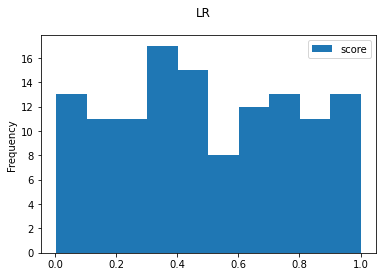

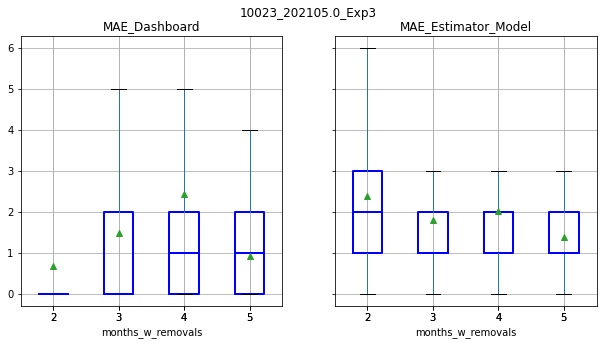

<Figure size 720x360 with 0 Axes>

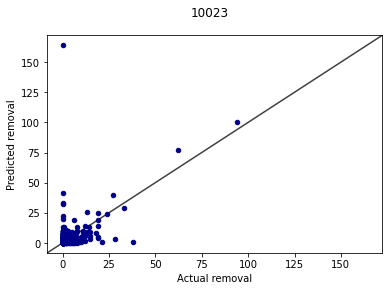

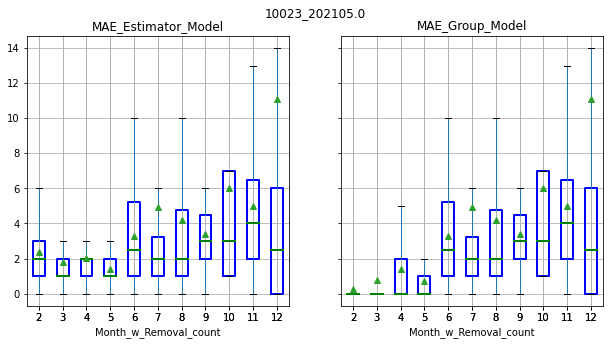

<Figure size 720x360 with 0 Axes>

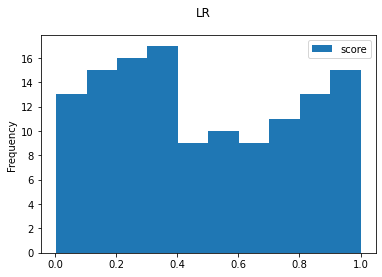

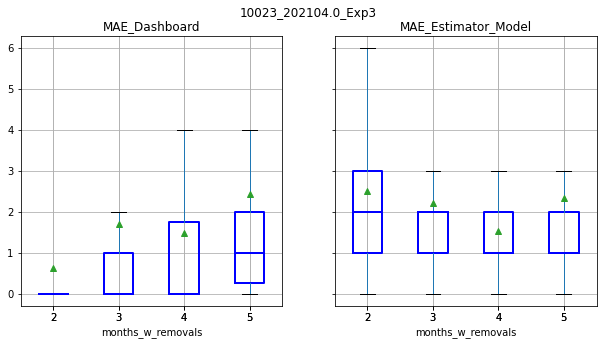

<Figure size 720x360 with 0 Axes>

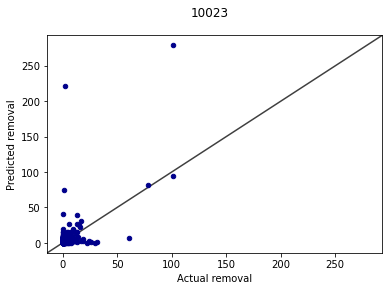

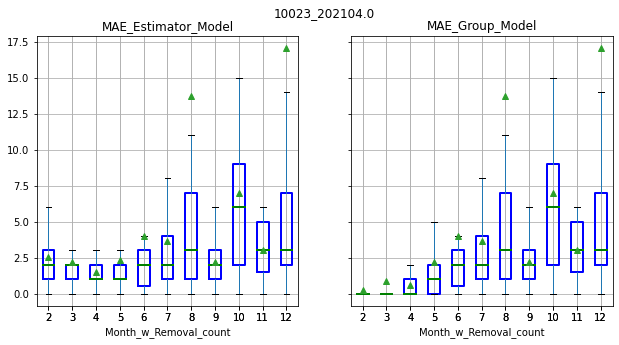

<Figure size 720x360 with 0 Axes>

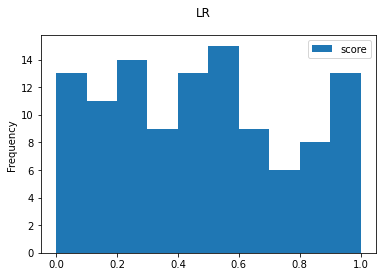

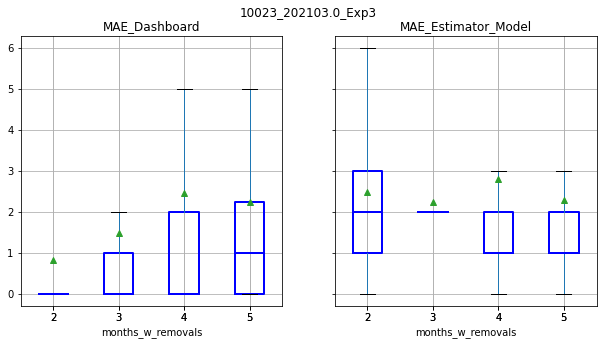

<Figure size 720x360 with 0 Axes>

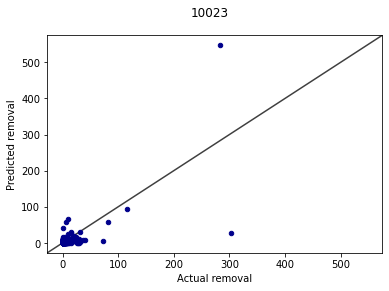

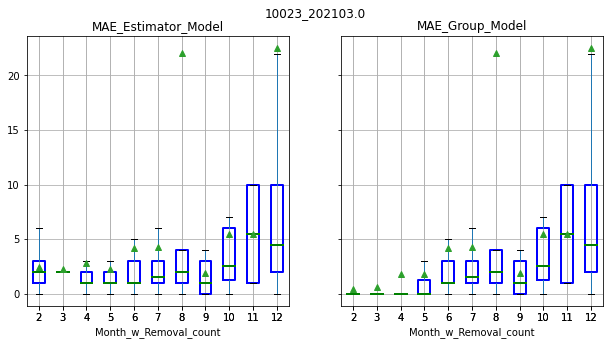

<Figure size 720x360 with 0 Axes>

In [86]:
model_list = ['LR']#, 'MARS']#, 'OLS'] #,'unitcost'
#All features = ['month2','100avgdailyusage30','inventoryquantity','dist_eed','dist_eed_120',max_par_level']
#Exp = 'Exp1'# Experiment 1
# features = ['month2','100avgdailyusage30','inventoryquantity','dist_eed','max_par_level']#,'standardstockwithindispensingdeviceflag'] #'month2',
#Exp = 'Exp2'# Experiment 2
#features = ['100avgdailyusage30','inventoryquantity','dist_eed','standardstockwithindispensingdeviceflag']#,'standardstockwithindispensingdeviceflag'] #'month2',
Exp = 'Exp3'# Experiment 3
features = ['100avgdailyusage30','inventoryquantity','dist_eed','max_par_level','standardstockwithindispensingdeviceflag']#,'standardstockwithindispensingdeviceflag'] #'month2',
#Exp = 'Exp4'# Experiment 4
# features = ['100avgdailyusage30','inventoryquantity','dist_eed','max_par_level']#,'standardstockwithindispensingdeviceflag'] #'month2',

allpairs = True#False#
grouped = True #False# 
trained_clientkey = clients_list[0] #16317#11537#13961#10550#12310#

#averageadily_usage_df=pd.read_csv('Averagedaily-10163.csv')
#first_date, second_date=get_training_mnth(averageadily_usage_df)

#training_first_ymints = [202003, 202004,202005]
training_first_ymints = get_training_months(usage)
#training_first_ymints = [first_date, second_date]
drop_unloaded = True

# group model functions parameters 
frequency_sample = {"freq_removal_2": 3,"freq_removal_3": 2.5,"freq_removal_4": 2.3, "freq_removal_5": 2} # these frequencies are hyperparamters
max_dist_eed=90  # group model function parameter 
max_dist_eed_current_dashboard=120 # parameters for months_remvoals equals 1 function
dashboard_percentage= 0.45
print('clientkey = ',trained_clientkey,"-",training_first_ymints[0])

for trained_clientkey in clients_list:
#training_first_ymint = 202002
    for training_first_ymint in training_first_ymints:
        for m in model_list:
            updated_features, lr_model, scores, modeled_pairs, min_max_scalers, modeled_pairs_count,result_grouped_df = Call_model(m, training_first_ymint, features, allpairs, grouped, trained_clientkey, Exp, drop_unloaded)
            #print(modeled_pairs,'\n')
            df_scores = pd.DataFrame(scores)
            df_scores.columns = ['score']
            df_scores.loc[df_scores['score'] >= 0].plot.hist()
            plt.suptitle(m)
            #print('\n', m,'\n',df_scores.describe(),'\n')

        Modeled_pair_count_df_record = {'clientkey':[trained_clientkey], 'training_first_month':[training_first_ymint],'modeled_pairs_count':[modeled_pairs_count]}
        Modeled_pair_count_df = Modeled_pair_count_df.append(pd.DataFrame(Modeled_pair_count_df_record))

    ## Predict for the test set (Validation)

    # Predict for the test set
        clientkey = trained_clientkey #10550#12310
        #Training_Pairs_One_Client = Training_Pairs.loc[Training_Pairs['skclientkey'] == clientkey].head(10)
        Training_Pairs_One_Client = modeled_pairs#.head(100)

        #e.g. training_first_ymint --> test_month ~ 202002 --> 202102
        test_month = training_first_ymint + 100
        print('test_month: ',test_month)
        counter = 0

        results = pd.DataFrame()
        included_pairs = pd.DataFrame()

        x_df = pd.DataFrame()
        x_test_df = pd.DataFrame()
        y_df = pd.DataFrame()
        y_predict_df = pd.DataFrame()

        for index, pair in Training_Pairs_One_Client.iterrows():
            skclientkey = pair.skclientkey
            medid = pair.medid
            devicekey = pair.device_naturalkey
            model_index, months_w_removal = get_pair_model_index(modeled_pairs, skclientkey, medid ,devicekey)
            #print(index, ': ',skclientkey,'-',medid,'-',device_naturalkey,'-',model_index)    
            if(model_index < 99999999):
                #print(model_index)
                min_max_scaler = min_max_scalers[model_index]
                model = lr_model[model_index]
                x, x_test, y_test = get_test_xy(df_tranx_all_grouped, test_month, features, skclientkey, medid ,devicekey, min_max_scaler)
                x_test_df = x_test_df.append(x_test)
                x_df = x_df.append(x)
                y_df = y_df.append(y_test)
                #print('x_test.count : ',x_test.count())
                if not(x_test.empty):
                    #print('Data found for ',skclientkey,' ' ,medid,' ' ,device_naturalkey)                
                    y_test_predicted = model.predict(x_test)
                    y_predict_df = y_predict_df.append(pd.DataFrame(y_test_predicted))
                    # record the results
                    included_pair = get_result_df(df_tranx_all_grouped, pair, x ,y_test,y_test_predicted,months_w_removal)
                    included_pairs = included_pairs.append(included_pair)

                else:
                    counter += 1
                    #print('no data found for ',skclientkey,' ' ,medid,' ' ,devicekey)                
            else:
                counter += 1
                print('no model found for ',skclientkey,' ' ,medid,' ' ,devicekey)
        print(counter, 'pairs in training set got no estimation')

        ## Built a dataframe of STE results

        # Print Errors with prediction cutoff -0% margin

        is_pair_prediction_cutoff = True # True to use the training set max removals as prediction cutoff
        margin_percent = 0
        STE_test_result = build_result_df(margin_percent, is_pair_prediction_cutoff ,training_first_ymint, updated_features, included_pairs, x_df, x_test_df, y_df, y_predict_df)
        Errors_df = add_errors(STE_test_result, Errors_df, trained_clientkey, test_month,is_pair_prediction_cutoff, margin_percent)

        box_plot_by_group(STE_test_result, margin_percent)
        
        
        # Add column with dollor value for STE and Dashboard model 
        
#         STE_test_result=pd.merge(STE_test_result,unitcost[['skclientkey','medid','unitcost']], how='left', on=['skclientkey','medid'])
#         STE_test_result['unitcost']=STE_test_result['unitcost'].fillna(0)
    
#         STE_test_result['STE_$_amount']=STE_test_result['unitcost']*STE_test_result['modified_y_predict_less_cons']
#         STE_test_result['Dashboard_$_amount']=STE_test_result['unitcost']*STE_test_result['Dashboard Estimate']
#         STE_test_result['Actual_$_amount']=STE_test_result['unitcost']*STE_test_result['y_df']
        
        STE_test_result.to_csv('STE_estimator_results_rev2_'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp +'_'+str(margin_percent)+'.csv')
        print(np.sqrt(STE_test_result[['MSE_Dashboard','MSE_Estimator_Model']].mean()))
        print(STE_test_result[['MAE_Dashboard','MAE_Estimator_Model']].mean())
        print('Maximum Error Percent: ',round(STE_test_result['Predicted_to_Actual'].max(),1))

        box_plot_individuals(STE_test_result, margin_percent)

        predict_vs_actual = STE_test_result[['y_df','modified_y_predict_less_cons']].rename(columns={'y_df':'Actual removal', 'modified_y_predict_less_cons': 'Predicted removal'})
        ax1 = predict_vs_actual.plot.scatter(x='Actual removal',
                              y='Predicted removal',
                              c='DarkBlue')#,figsize=(20,20))
        lims = [
            np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
            np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
        ]
        plt.suptitle(trained_clientkey)
        # now plot both limits against eachother
        ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
        #ax1.set_aspect('equal')
        ax1.set_xlim(lims)
        ax1.set_ylim(lims)

        ax1.get_figure().savefig(str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp+'_'+str(margin_percent)+'.png')
        
        
        ## Prediction using group model
        group_dataframe =pd.merge(result_grouped_df,STE_test_result[['skclientkey','medid','device_naturalkey','max_par_level','standardstockwithindispensingdeviceflag','100avgdailyusage30','inventoryquantity','dist_eed','y_df','y_predict','modified_y_predict_less_cons','transactionquantity','Dashboard Estimate','MSE_Dashboard','MSE_Estimator_Model','MAE_Estimator_Model','MAE_Dashboard']], how='inner', on=['skclientkey','medid','device_naturalkey'])
        test_month_group=group_test_month(test_month)
        STE_group_test_result=prediction_by_group_model(group_dataframe,test_month_group,max_dist_eed,frequency_sample)
        
        STE_group_test_result.to_csv('STE_estimator_group_results_rev2_'+str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp +'_'+str(margin_percent)+'.csv')
        
        box_plot_group_model(STE_group_test_result, margin_percent)

        # Print Errors with prediction cutoff 0% margin

        print(str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp)


        #model_params.to_csv('STE LR model Parameters_'+str(trained_clientkey)+'_starts_'+str(training_first_ymint)+'_'+Exp+'.csv')

        #print(str(trained_clientkey)+'_'+ str(test_month)+'_'+ Exp)

## To be printed after running for all sites in this notebook

In [87]:
Errors_df.sort_values(['skclientkey','test_month','is_pair_prediction_cutoff','margin_percent']).to_csv('errors_hubers_'+clients+'.csv')
Modeled_pair_count_df.sort_values(['clientkey','training_first_month']).to_csv('trained_pairs_count'+clients+'.csv')

In [88]:
df_tranx_all_grouped.to_csv('df_tranx_all_grouped_'+clients+'.csv')

## Print Outliers

# find outliers: error percentage less than 50% or more than 200% 

# 12310: 377 out of 934

STE_result_Outliers = STE_test_result
STE_result_Outliers = STE_result_Outliers.loc[((STE_result_Outliers['Predicted_to_Actual']>2) & (STE_result_Outliers['Predicted_to_Actual']<10)) | (STE_result_Outliers['Predicted_to_Actual'] < 0.5)].sort_values(by = 'Predicted_to_Actual',ascending=False)
STE_result_Outliers.to_csv('STE_result_Outliers_'+str(trained_clientkey)+'_'+str(test_month)+'_'+Exp+'.csv')

STE_result_Outliers.count() #541
STE_result_Outliers.groupby('month2').count() # 1: #295 2: #246
STE_result_Outliers.groupby('model_index').count() #individuals: #347 group2: #35 group3: #51 group4: #41 group5: #67

## Print the extracted features

# Standard Stock Flag changes over time: 

## 108 pairs out of 7,547 -> (10550: 55/3,196) & (12310: 53/4,352)

ssflog = df_tranx_all_grouped.groupby(['skclientkey','medid','dispensingdevicename']).standardstockwithindispensingdeviceflag.mean().reset_index()
print(ssflog.groupby('skclientkey').count())
ssflog.loc[(ssflog['standardstockwithindispensingdeviceflag'] != 1) & (ssflog['standardstockwithindispensingdeviceflag'] != 0)].groupby('skclientkey').count()

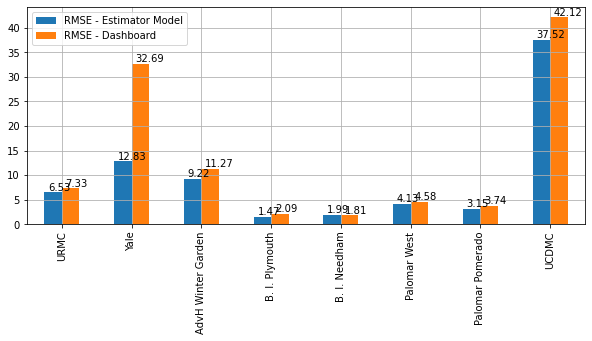

In [10]:
# 3.31 result review slide
import pandas as pd
#RMSE = pd.DataFrame(index = ['URMC', 'Yale'], data ={ 'RMSE - Estimator Model' : [5.84, 17.78], 'RMSE - Dashboard': [6.02, 23.79]})
RMSE = pd.DataFrame(index = ['URMC', 'Yale', 'AdvH Winter Garden','B. I. Plymouth','B. I. Needham', 'Palomar West','Palomar Pomerado', 'UCDMC'], data ={ 'RMSE - Estimator Model' : [6.53, 12.83,9.22,1.47,1.99,4.132, 3.146,37.517], 'RMSE - Dashboard': [7.33,32.69,11.27, 2.09, 1.81,4.576, 3.738,42.123]})
#RMSE = pd.DataFrame(index = ['URMC', 'Yale', 'AdvH Winter Garden', 'Palomar West','Palomar Pomerado'], data ={ 'RMSE - Estimator Model' : [6.43, 12.76,9.215,4.105, 3.125], 'RMSE - Dashboard': [7.20,32.56,11.44, 4.54, 3.735]})
#RMSE.plot.bar()
ax = RMSE.plot(kind='bar',figsize=(10,4), grid = True) #, color=['orange','b']
x_offset = -0.07
y_offset = 0.4
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))
